In [57]:
import numpy as np
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split



In [58]:
df=pd.read_csv('laptop_data.csv')
df.head()

,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [59]:

def explore_data(df):
    # Shape of DataFrame
    shape_headers = ["Number of Rows", "Number of Columns"]
    shape_data = [(df.shape[0], df.shape[1])]
    
    # Info of DataFrame
    info_data = []
    for col in df.columns:
        info_data.append((col, df[col].count(), df[col].dtype))
    
    # Data Types
    dtypes_headers = ["Column", "Data Type"]
    dtypes_data = [(col, df[col].dtype) for col in df.columns]
    
    # Missing Values
    missing_values = df.isnull().sum()
    missing_headers = ["Column", "Missing Values"]
    missing_data = [(col, count if count != 0 else "Zero") for col, count in missing_values.items()]
    
    # Summary Statistics
    summary_stats = df.describe()
    
    # Value Counts Column-wise
    value_counts_data = []
    for column in df.columns:
        counts = df[column].value_counts().reset_index()
        counts.columns = ['Value', 'Count']
        value_counts_data.append((f"Value Counts for {column}", counts))

    # Displaying results using tabulate
    print("\n\n~~~~~ Shape of DataFrame ~~~~~")
    print(tabulate(shape_data, headers=shape_headers, tablefmt="pretty"))

    print("\n\n~~~~~ Info of DataFrame ~~~~~")
    print(tabulate(info_data, headers=["Column", "Non-Null Count", "Dtype"], tablefmt="grid"))

    print("\n\n~~~~~ Data Types ~~~~~")
    print(tabulate(dtypes_data, headers=dtypes_headers, tablefmt="pretty"))

    print("\n\n~~~~~ Missing Values ~~~~~")
    print(tabulate(missing_data, headers=missing_headers, tablefmt="pretty"))

    print("\n\n~~~~~ Summary Statistics ~~~~~")
    print(tabulate(summary_stats, headers='keys', tablefmt="grid"))



explore_data(df)




~~~~~ Shape of DataFrame ~~~~~
+----------------+-------------------+
| Number of Rows | Number of Columns |
+----------------+-------------------+
|      1303      |        12         |
+----------------+-------------------+


~~~~~ Info of DataFrame ~~~~~
+------------------+------------------+---------+
| Column           |   Non-Null Count | Dtype   |
+==================+==================+=========+
| Unnamed: 0       |             1303 | int64   |
+------------------+------------------+---------+
| Company          |             1303 | object  |
+------------------+------------------+---------+
| TypeName         |             1303 | object  |
+------------------+------------------+---------+
| Inches           |             1303 | float64 |
+------------------+------------------+---------+
| ScreenResolution |             1303 | object  |
+------------------+------------------+---------+
| Cpu              |             1303 | object  |
+------------------+------------------+-

In [60]:
# Drop the 'Unnamed: 0' column if present
df.drop(columns='Unnamed: 0', inplace=True)

# Remove 'GB' from Ram column and convert it to integer
df['Ram'] = df['Ram'].str.strip("GB")
df['Ram'] = df['Ram'].astype(int)

# Remove 'kg' from Weight column and convert it to float
df['Weight'] = df['Weight'].str.strip("kg")
df['Weight'] = df['Weight'].astype(float)

# Create binary columns for Touchscreen and IPS based on ScreenResolution
df['Touchscreen'] = df['ScreenResolution'].apply(lambda x: 1 if 'Touchscreen' in x else 0)
df['IPS'] = df['ScreenResolution'].apply(lambda x: 1 if 'IPS' in x else 0)

# Extract X and Y resolution from ScreenResolution
df[['X_res', 'Y_res']] = df['ScreenResolution'].str.split('x', n=1, expand=True)

# Extract numeric values from X_res and Y_res using regular expression
df['X_res'] = df['X_res'].str.replace(',', '').str.findall(r'(\d+\.*\d*)').str[0].astype(int)
df['Y_res'] = df['Y_res'].str.replace(',', '').str.findall(r'(\d+\.*\d*)').str[0].astype(int)

# Calculate diagonal resolution
df['Diagonal_resolution'] = (df['X_res']**2 + df['Y_res']**2) ** 0.5

# Calculate PPI using the formula
df['ppi'] = df['Diagonal_resolution'] / df['Inches']

# cpu name
df['Cpu Name'] = df['Cpu'].apply(lambda x:" ".join(x.split()[0:3]))
# cpu brand name
def fetch_processor(text):
    if text == 'Intel Core i7' or text == 'Intel Core i5' or text == 'Intel Core i3':
        return text
    else:
        if text.split()[0] == 'Intel':
            return 'Other Intel Processor'
        else:
            return 'AMD Processor'

df['Cpu brand'] = df['Cpu Name'].apply(fetch_processor)



# treating memory column
def extract_memory_details(memory):
    details = memory.replace('TB', '000').replace('GB', '').split('+')
    details = [detail.strip() for detail in details]
    
    hdd, ssd, hybrid, flash_storage = 0, 0, 0, 0
    for detail in details:
        if 'HDD' in detail:
            hdd += int(''.join(filter(str.isdigit, detail)))
        elif 'SSD' in detail:
            ssd += int(''.join(filter(str.isdigit, detail)))
        elif 'Hybrid' in detail:
            hybrid += int(''.join(filter(str.isdigit, detail)))
        elif 'Flash Storage' in detail:
            flash_storage += int(''.join(filter(str.isdigit, detail)))
    
    return pd.Series({'HDD': hdd, 'SSD': ssd, 'Hybrid': hybrid, 'Flash_Storage': flash_storage})

# Apply the function to each row of the 'Memory' column
df[['HDD', 'SSD', 'Hybrid', 'Flash_Storage']] = df['Memory'].apply(extract_memory_details)

# Drop the original 'Memory' column
df.drop(columns=['Memory'], inplace=True)

# Display the modified DataFrame
df.head()


,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Gpu,OpSys,Weight,Price,...,X_res,Y_res,Diagonal_resolution,ppi,Cpu Name,Cpu brand,HDD,SSD,Hybrid,Flash_Storage
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,Intel Iris Plus Graphics 640,macOS,1.37,71378.6832,...,2560,1600,3018.873962,226.983005,Intel Core i5,Intel Core i5,0,128,0,0
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,Intel HD Graphics 6000,macOS,1.34,47895.5232,...,1440,900,1698.116604,127.677940,Intel Core i5,Intel Core i5,0,0,0,128
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,Intel HD Graphics 620,No OS,1.86,30636.0000,...,1920,1080,2202.907170,141.211998,Intel Core i5,Intel Core i5,0,256,0,0
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,AMD Radeon Pro 455,macOS,1.83,135195.3360,...,2880,1800,3396.233208,220.534624,Intel Core i7,Intel Core i7,0,512,0,0
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,Intel Iris Plus Graphics 650,macOS,1.37,96095.8080,...,2560,1600,3018.873962,226.983005,Intel Core i5,Intel Core i5,0,256,0,0


In [61]:
df['Gpu'].value_counts()
df['Gpu brand'] = df['Gpu'].apply(lambda x:x.split()[0])
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Gpu,OpSys,Weight,Price,...,Y_res,Diagonal_resolution,ppi,Cpu Name,Cpu brand,HDD,SSD,Hybrid,Flash_Storage,Gpu brand
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,Intel Iris Plus Graphics 640,macOS,1.37,71378.6832,...,1600,3018.873962,226.983005,Intel Core i5,Intel Core i5,0,128,0,0,Intel
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,Intel HD Graphics 6000,macOS,1.34,47895.5232,...,900,1698.116604,127.677940,Intel Core i5,Intel Core i5,0,0,0,128,Intel
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,Intel HD Graphics 620,No OS,1.86,30636.0000,...,1080,2202.907170,141.211998,Intel Core i5,Intel Core i5,0,256,0,0,Intel
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,AMD Radeon Pro 455,macOS,1.83,135195.3360,...,1800,3396.233208,220.534624,Intel Core i7,Intel Core i7,0,512,0,0,AMD
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,Intel Iris Plus Graphics 650,macOS,1.37,96095.8080,...,1600,3018.873962,226.983005,Intel Core i5,Intel Core i5,0,256,0,0,Intel


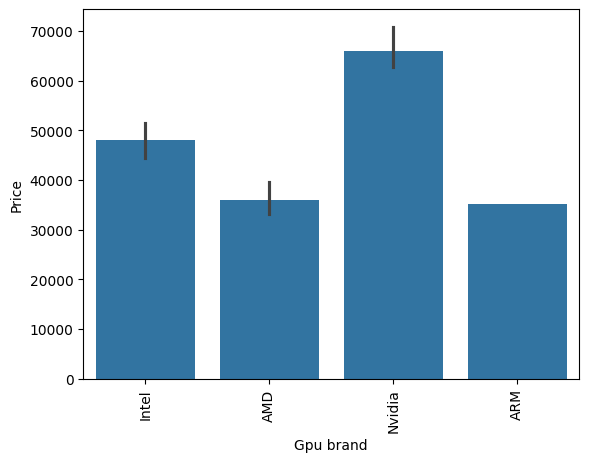

In [62]:
df['Gpu brand'].value_counts()
sns.barplot(x=df['Gpu brand'],y=df['Price'],estimator=np.median)
plt.xticks(rotation='vertical')
plt.show()




In [63]:
df['OpSys'].value_counts()
def cat_os(inp):
    if inp == 'Windows 10' or inp == 'Windows 7' or inp == 'Windows 10 S':
        return 'Windows'
    elif inp == 'macOS' or inp == 'Mac OS X':
        return 'Mac'
    else:
        return 'Others/No OS/Linux'
df['os'] = df['OpSys'].apply(cat_os)

C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\2299765943.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


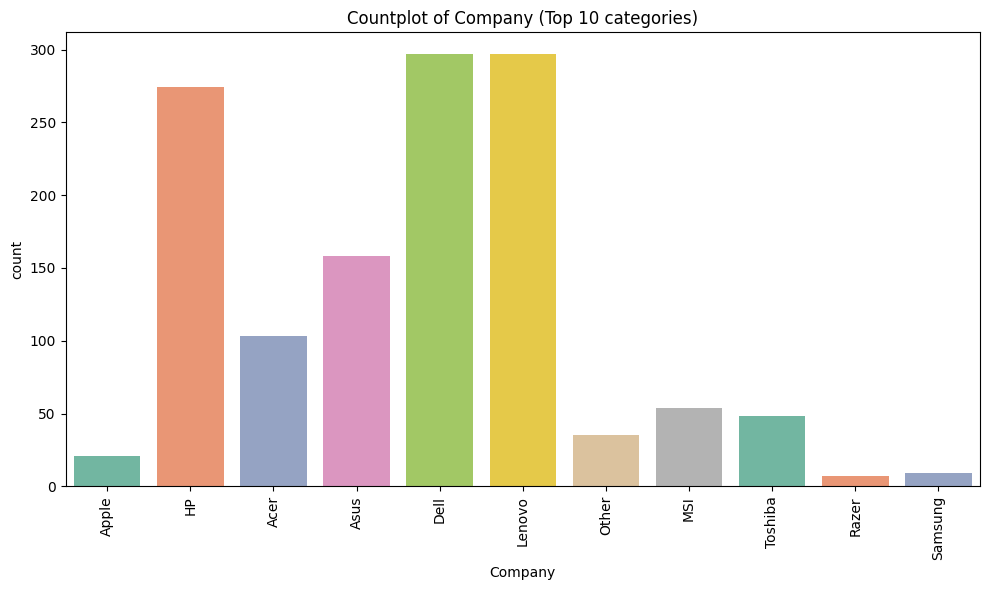

C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\2299765943.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


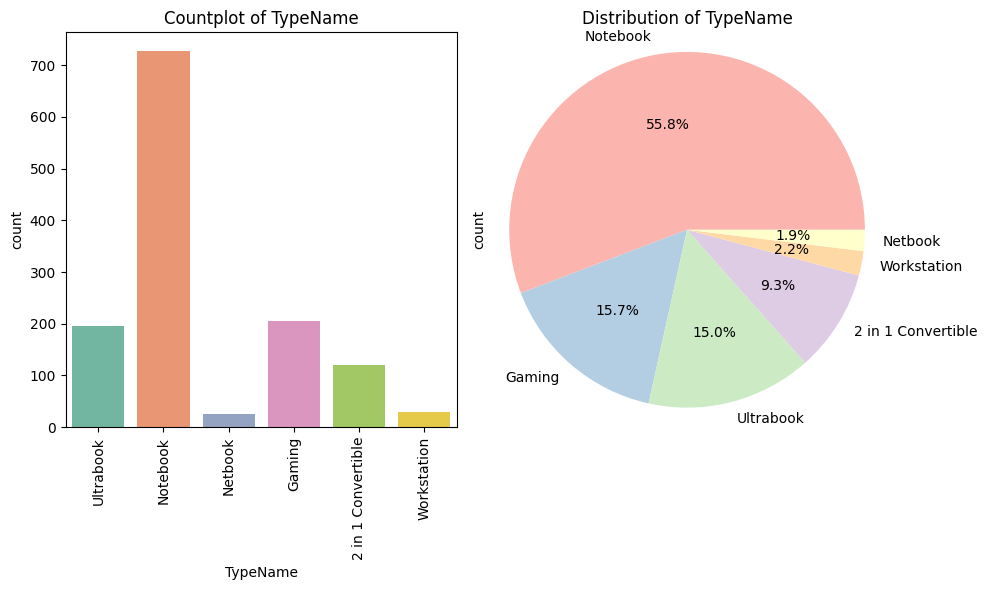

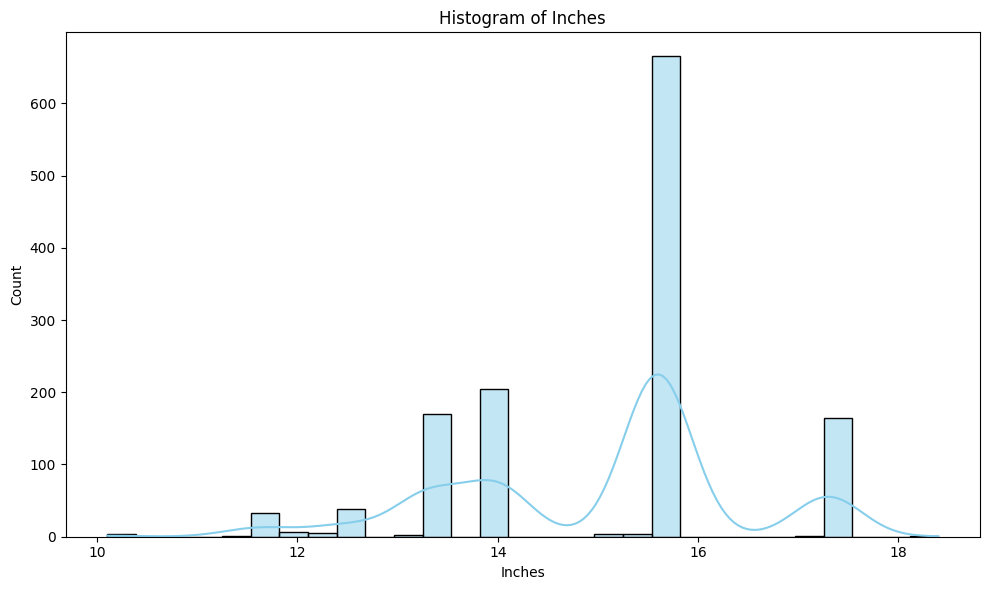

C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\2299765943.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


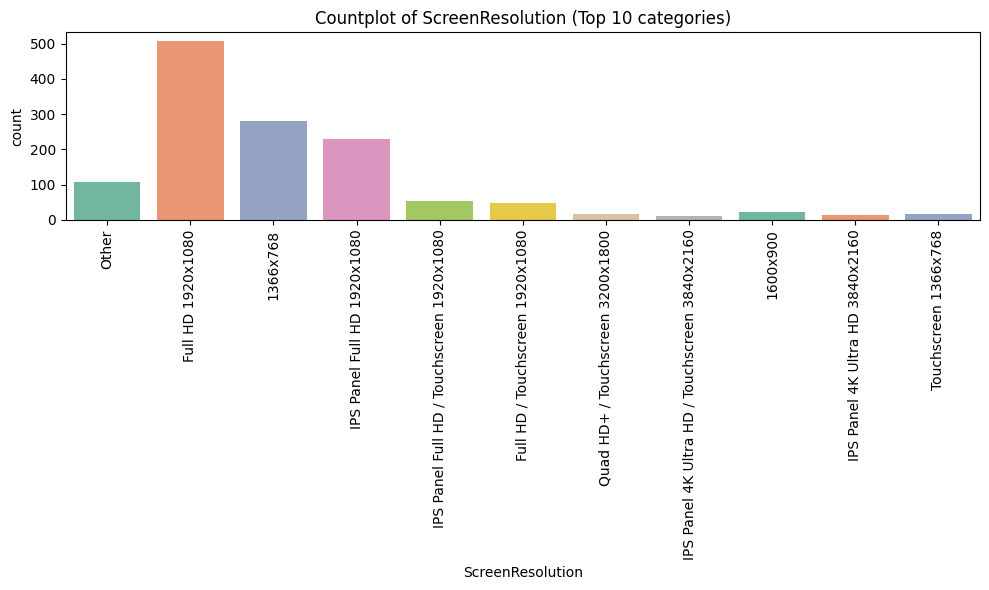

C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\2299765943.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


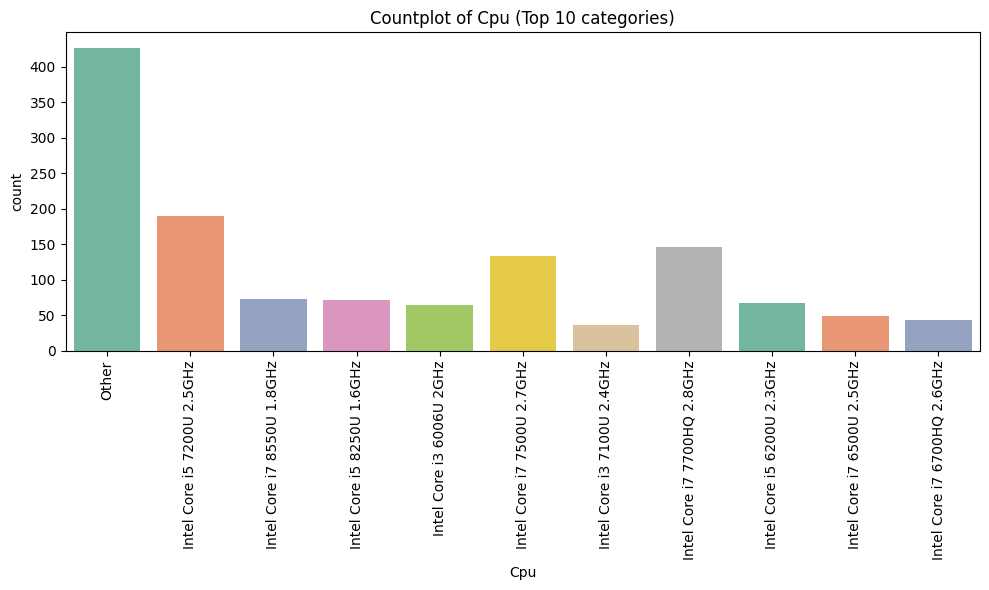

<Figure size 1000x600 with 0 Axes>

C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\2299765943.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


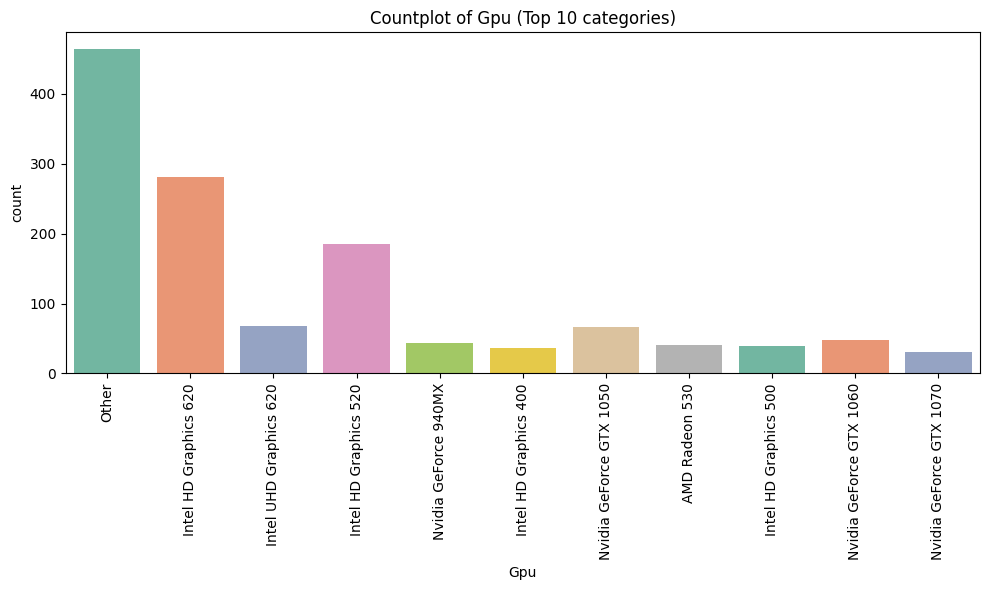

C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\2299765943.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


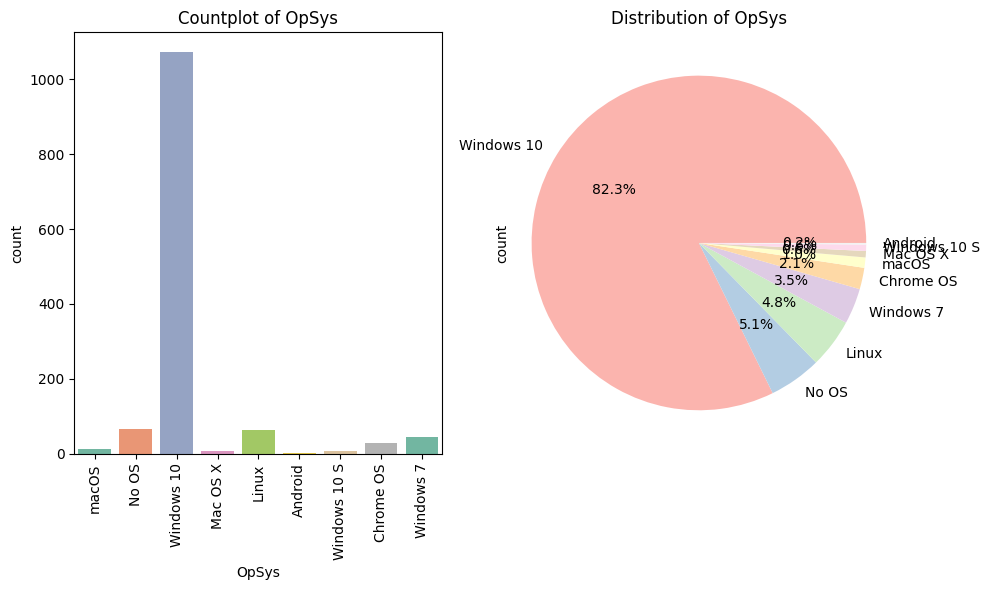

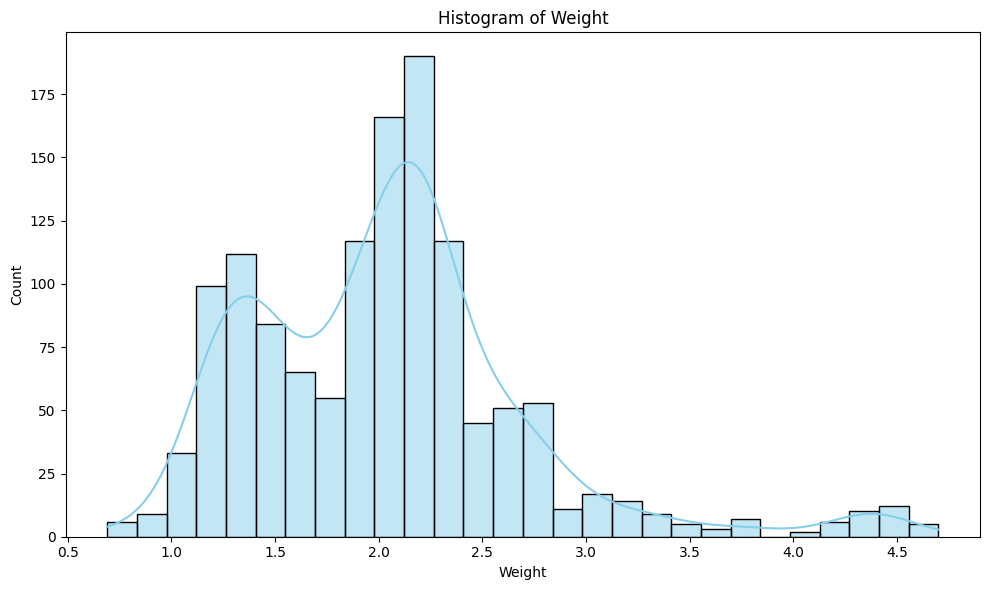

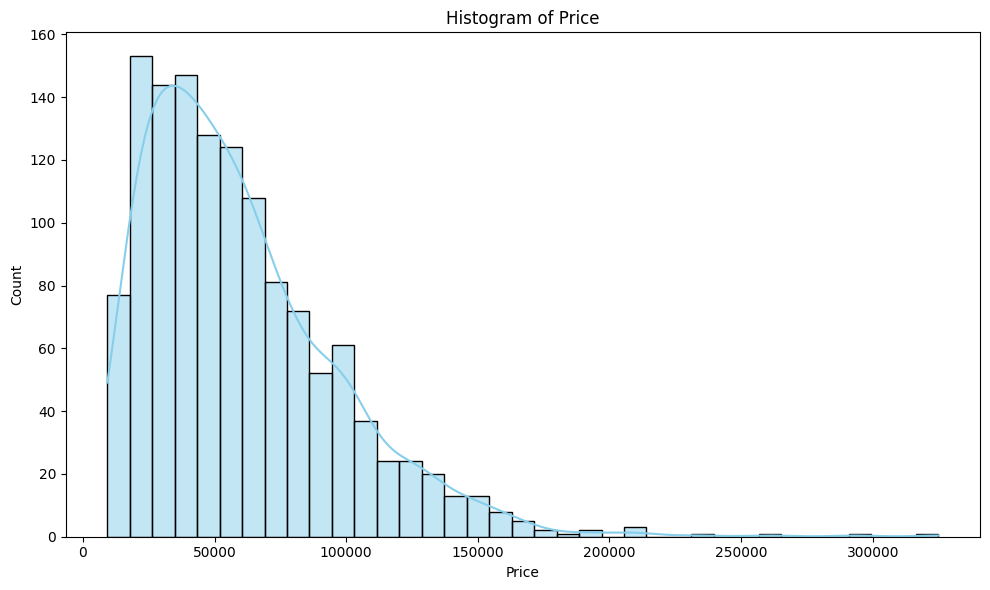

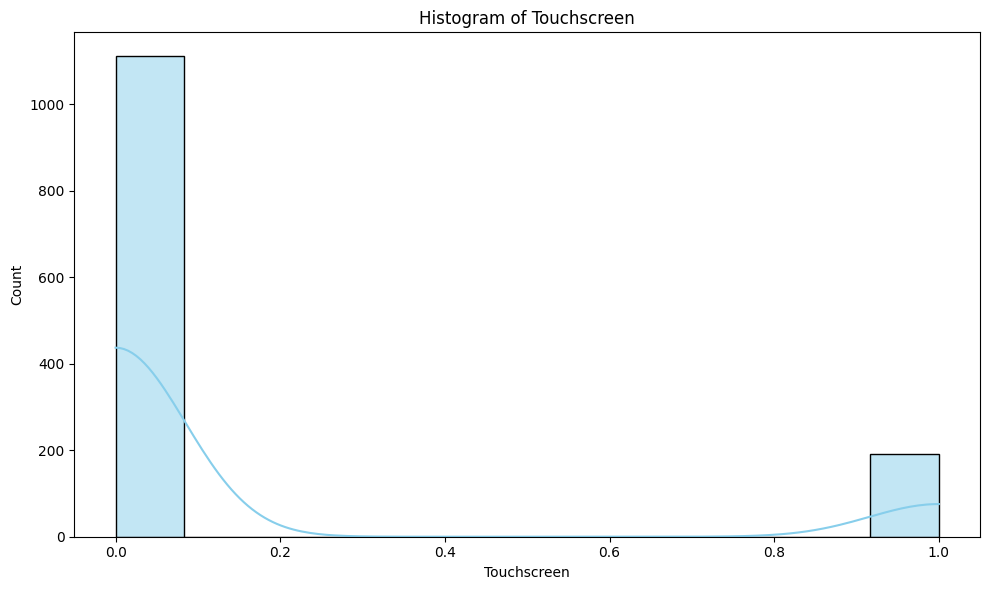

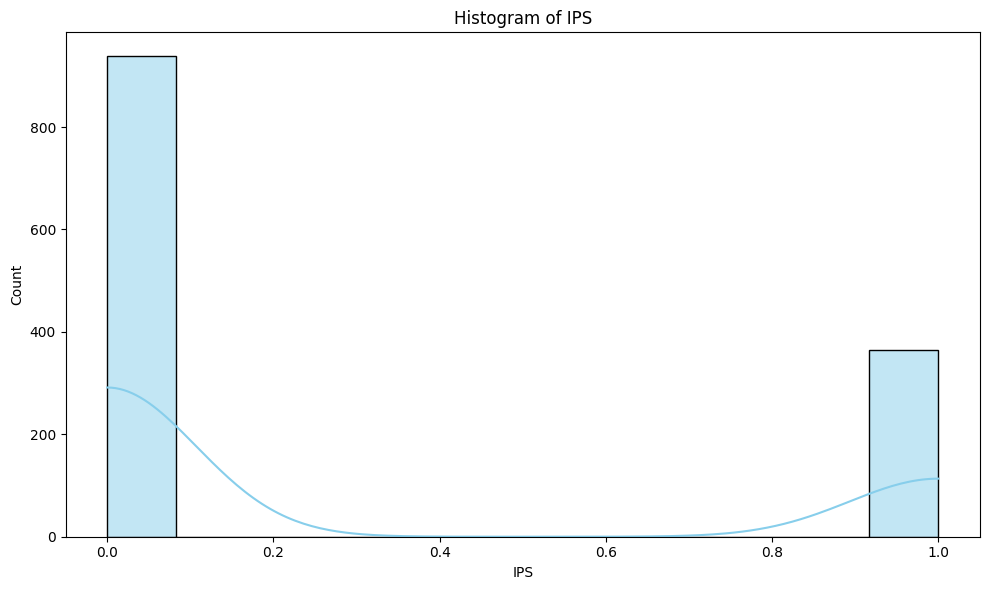

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

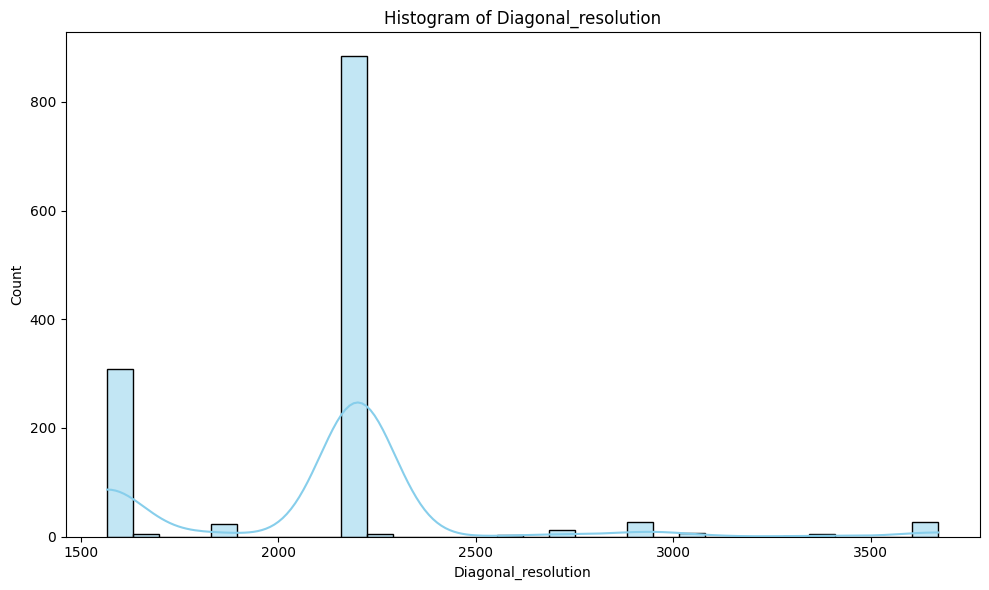

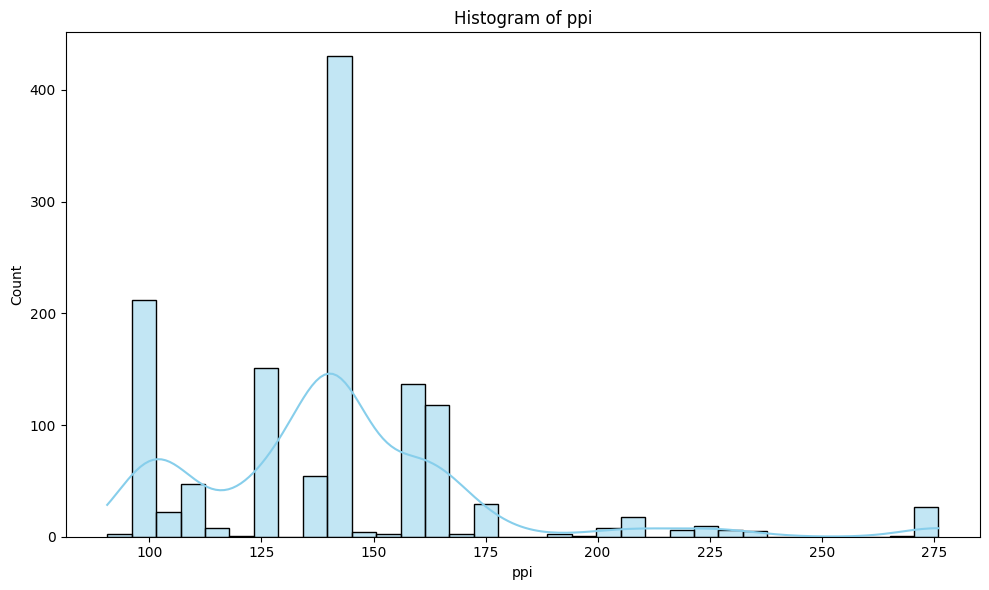

C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\2299765943.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


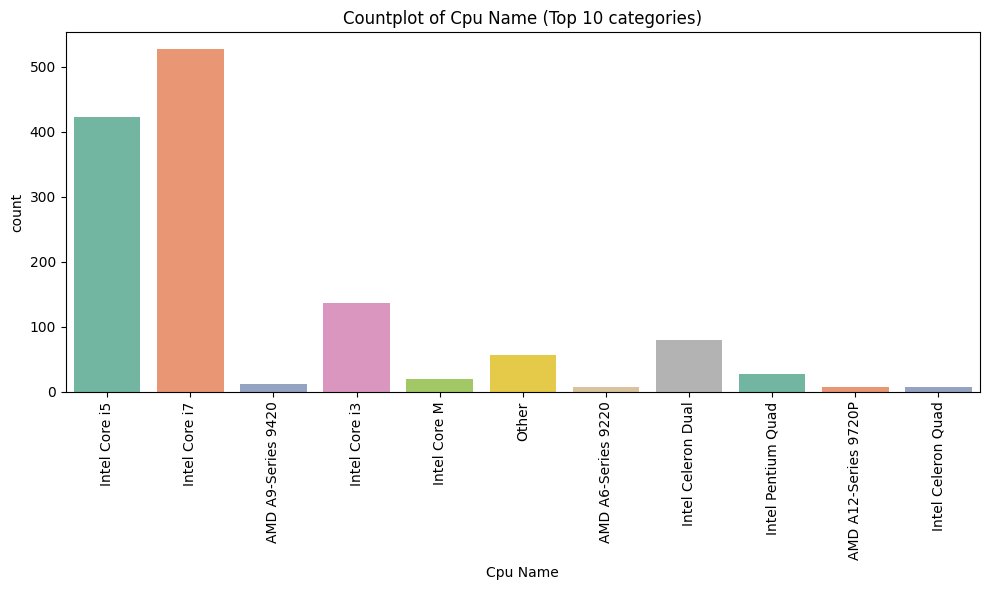

C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\2299765943.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


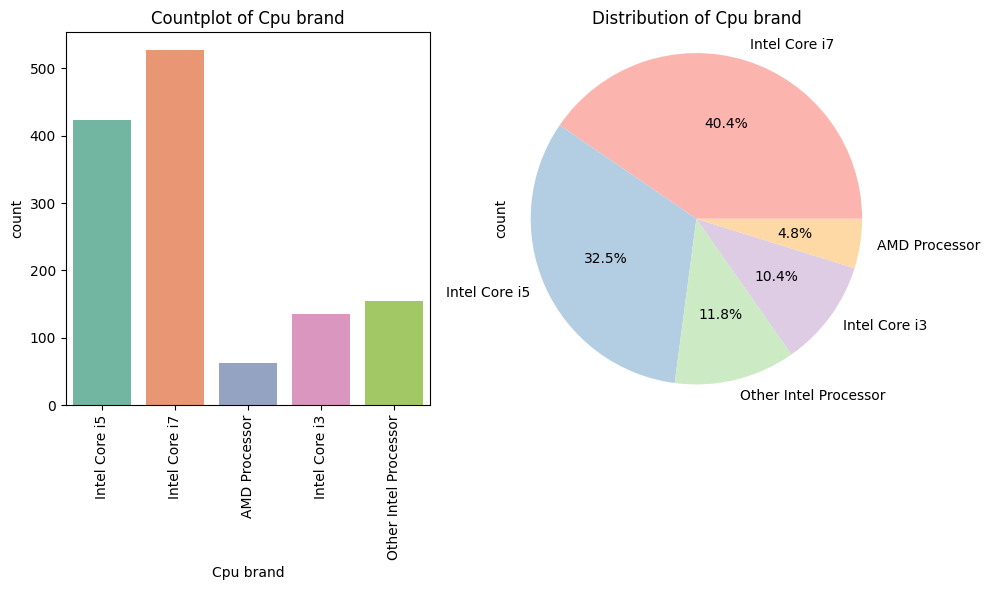

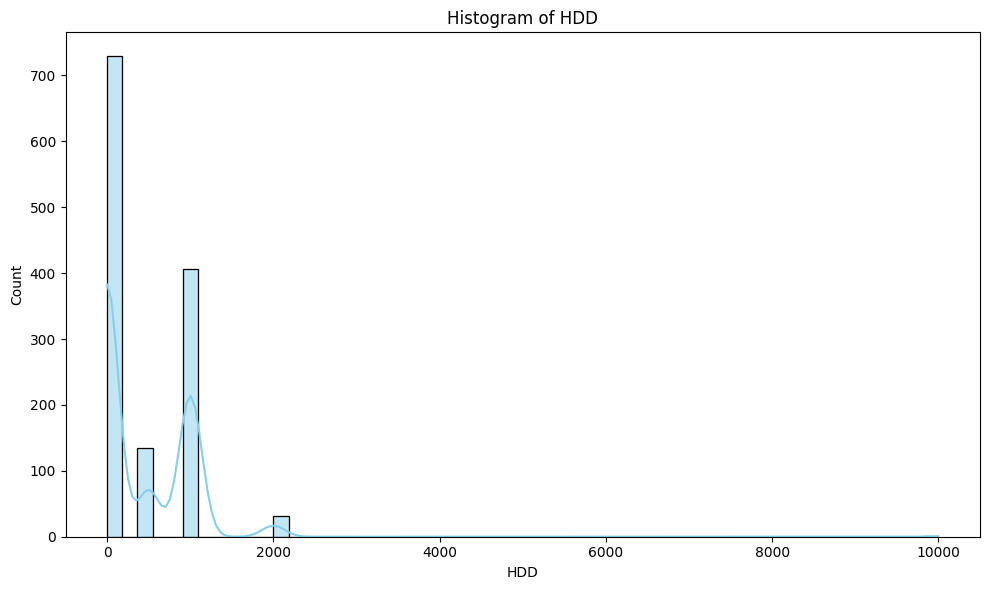

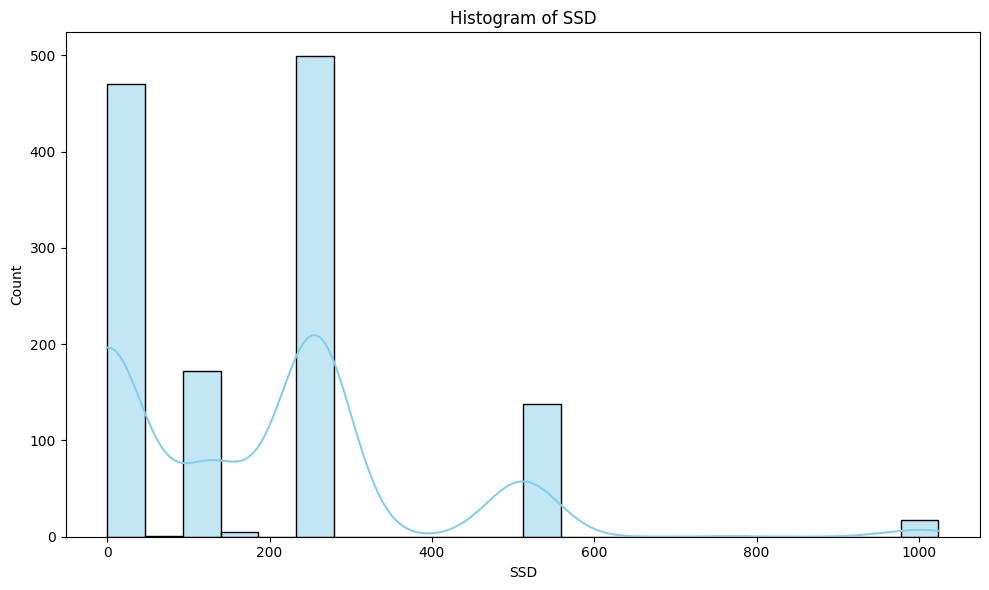

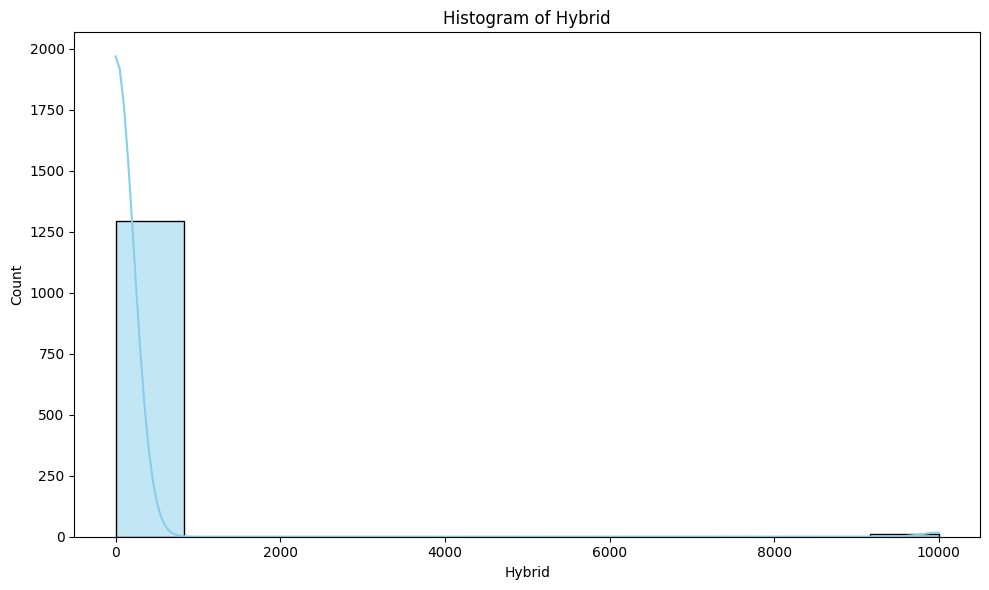

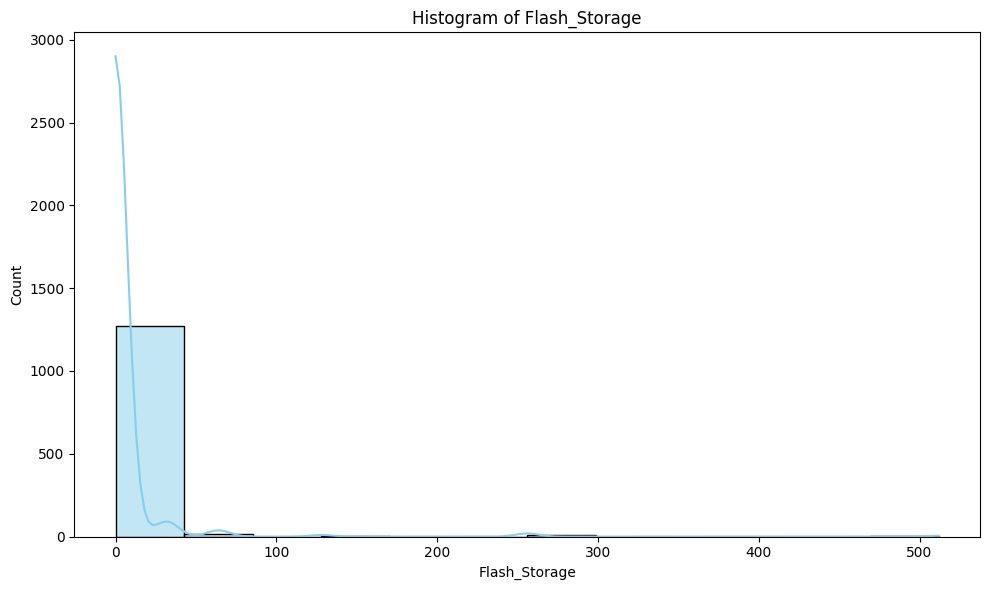

C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\2299765943.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


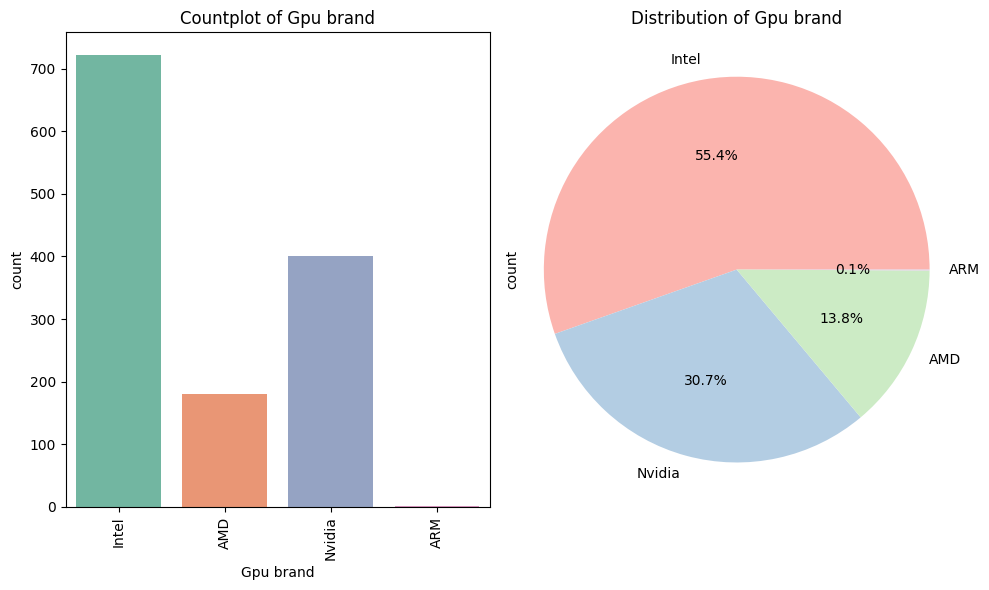

C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\2299765943.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='Set2')


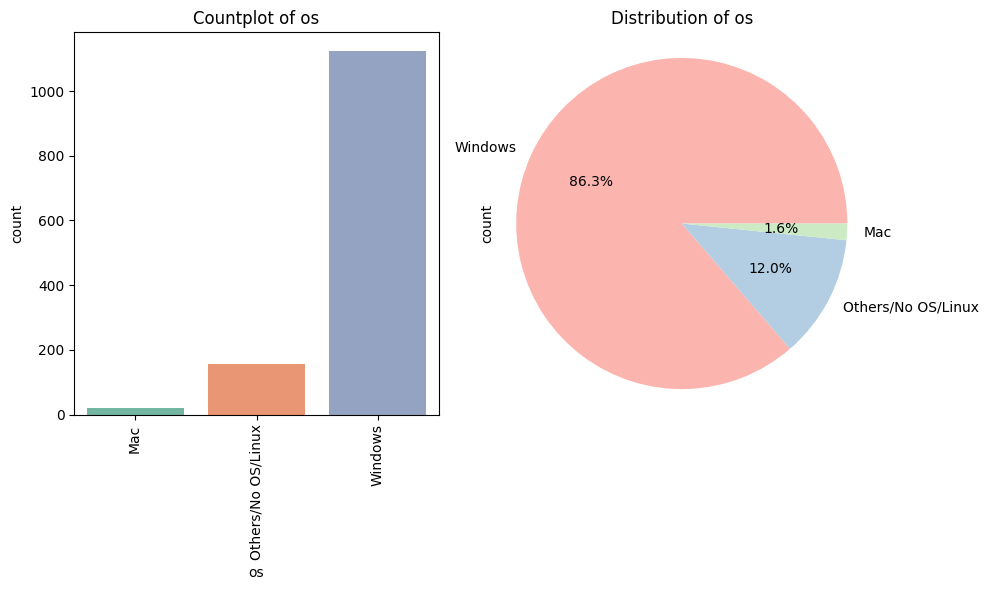

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def univariate_analysis(df, threshold=10):
    """
    Perform univariate analysis on all columns of the dataframe.

    Parameters:
    - df: DataFrame
    - threshold: int, threshold number of categories for which detailed analysis is performed
    """
    for column in df.columns:
        plt.figure(figsize=(10, 6))
        unique_values = df[column].nunique()
        if df[column].dtype == 'object':
            # For object type columns (categorical)
            if unique_values <= threshold:
                plt.subplot(1, 2, 1)
                sns.countplot(data=df, x=column, palette='Set2')
                plt.xticks(rotation=90)
                plt.title(f'Countplot of {column}')

                plt.subplot(1, 2, 2)
                df[column].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('Pastel1'))
                plt.title(f'Distribution of {column}')
                plt.axis('equal')
            else:
                # Aggregate less frequent categories into "Other"
                top_categories = df[column].value_counts().index[:threshold]
                df[column] = df[column].apply(lambda x: x if x in top_categories else 'Other')
                sns.countplot(data=df, x=column, palette='Set2')
                plt.xticks(rotation=90)
                plt.title(f'Countplot of {column} (Top {threshold} categories)')
        elif df[column].dtype in ['int64', 'float64']:
            # For numerical type columns
            sns.histplot(data=df, x=column, kde=True, color='skyblue')
            plt.title(f'Histogram of {column}')
            
        plt.tight_layout()
        plt.show()

# Reset the index of the DataFrame
df.reset_index(drop=True, inplace=True)
# Call the function with your DataFrame
univariate_analysis(df)



In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

def bivariate_analysis(df, x_column, y_column):
    """
    Perform bivariate analysis between two columns of the dataframe using different charts from Seaborn.

    Parameters:
    - df: DataFrame
    - x_column: str, name of the first column
    - y_column: str, name of the second column
    """
    # Create an increasing color palette
    num_categories = len(df[x_column].unique())
    color_palette = sns.color_palette("viridis", num_categories)

    plt.figure(figsize=(20, 7))

    # Box plot
    plt.subplot(1, 3, 1)
    if df[x_column].dtype == 'object':
        sns.boxplot(data=df, x=x_column, y=y_column, palette=color_palette)
        plt.xticks(rotation=90)
        plt.title(f'Bivariate Boxplot between {x_column} and {y_column}')

    # Bar plot
    plt.subplot(1, 3, 2)
    if df[x_column].dtype == 'object':
        sns.barplot(data=df, x=x_column, y=y_column, palette=color_palette)
        plt.xticks(rotation=90)
        plt.title(f'Bivariate Barplot between {x_column} and {y_column}')

    # Point plot
    plt.subplot(1, 3, 3)
    if df[x_column].dtype == 'object':
        sns.pointplot(data=df, x=x_column, y=y_column, palette=color_palette)
        plt.xticks(rotation=90)
        plt.title(f'Bivariate Pointplot between {x_column} and {y_column}')

    plt.tight_layout()
    plt.show()

# Example usage:
# bivariate_analysis(df, 'Categorical_Column', 'Numeric_Column')


C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\902243052.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x_column, y=y_column, palette=color_palette)
C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\902243052.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=x_column, y=y_column, palette=color_palette)
C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\902243052.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data=df, x=x_column, y=y_column, palette=color_palette)


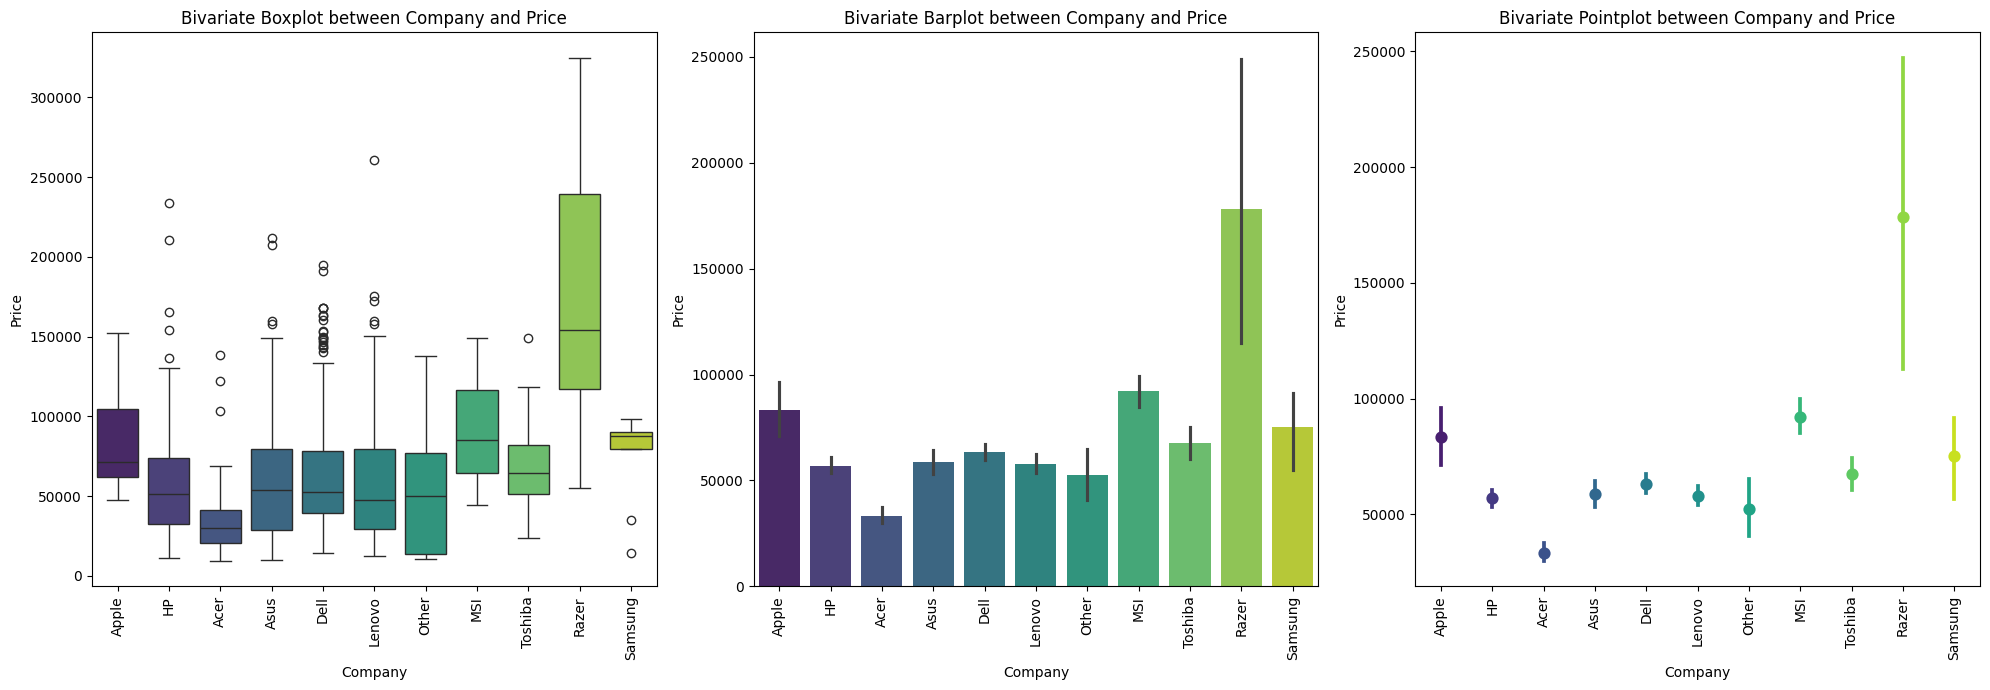

In [66]:
bivariate_analysis(df, 'Company', 'Price')




C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\902243052.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x_column, y=y_column, palette=color_palette)
C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\902243052.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=x_column, y=y_column, palette=color_palette)
C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\902243052.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data=df, x=x_column, y=y_column, palette=color_palette)


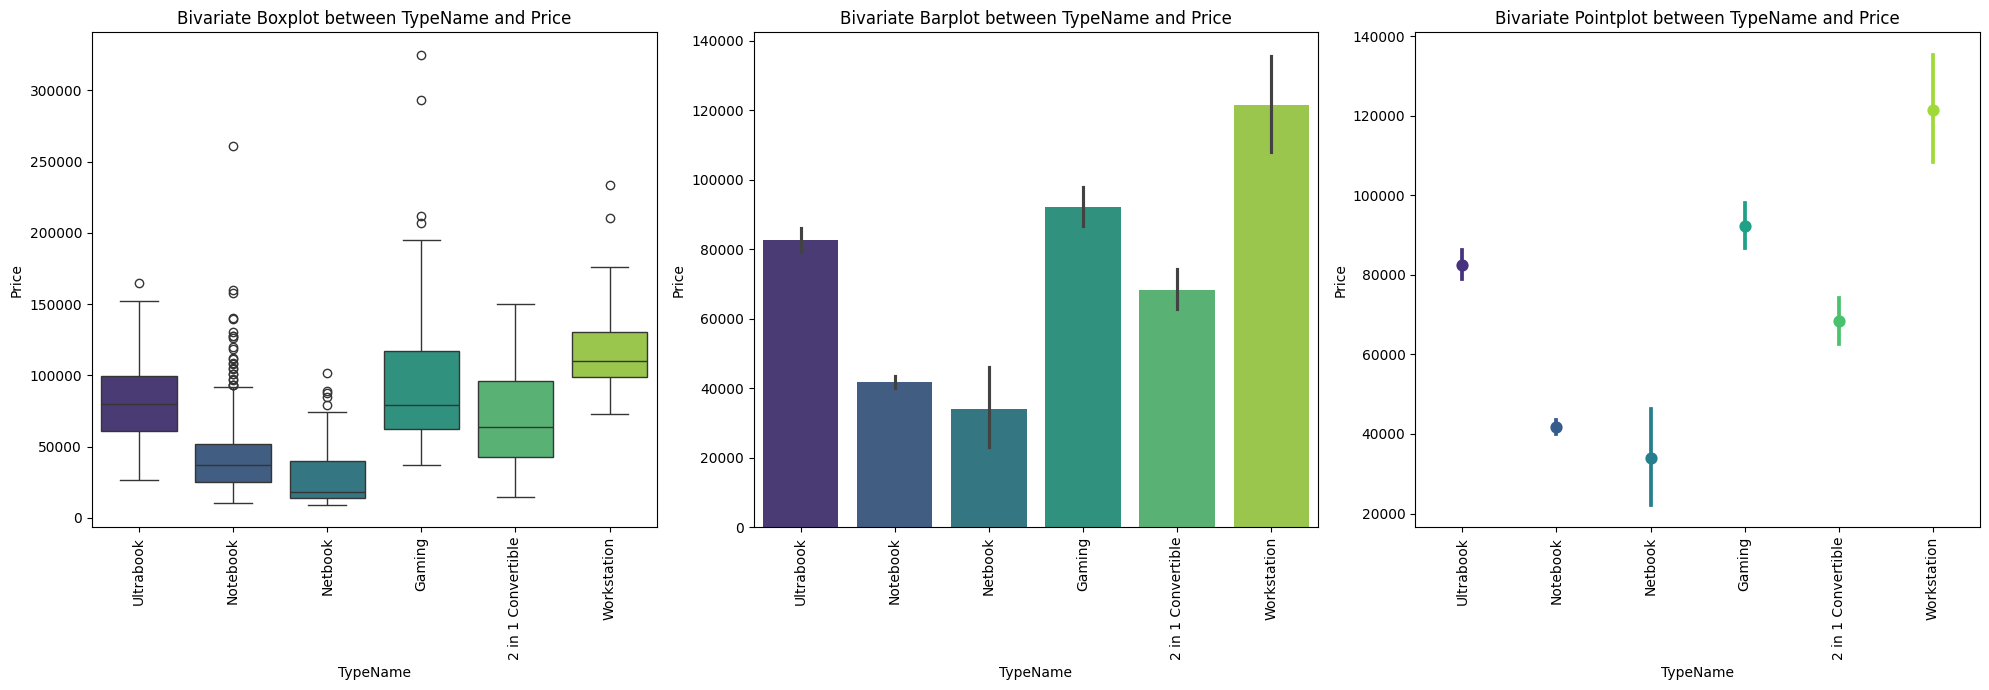

In [67]:
bivariate_analysis(df, 'TypeName', 'Price')

C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\902243052.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x_column, y=y_column, palette=color_palette)
C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\902243052.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=x_column, y=y_column, palette=color_palette)
C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\902243052.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data=df, x=x_column, y=y_column, palette=color_palette)


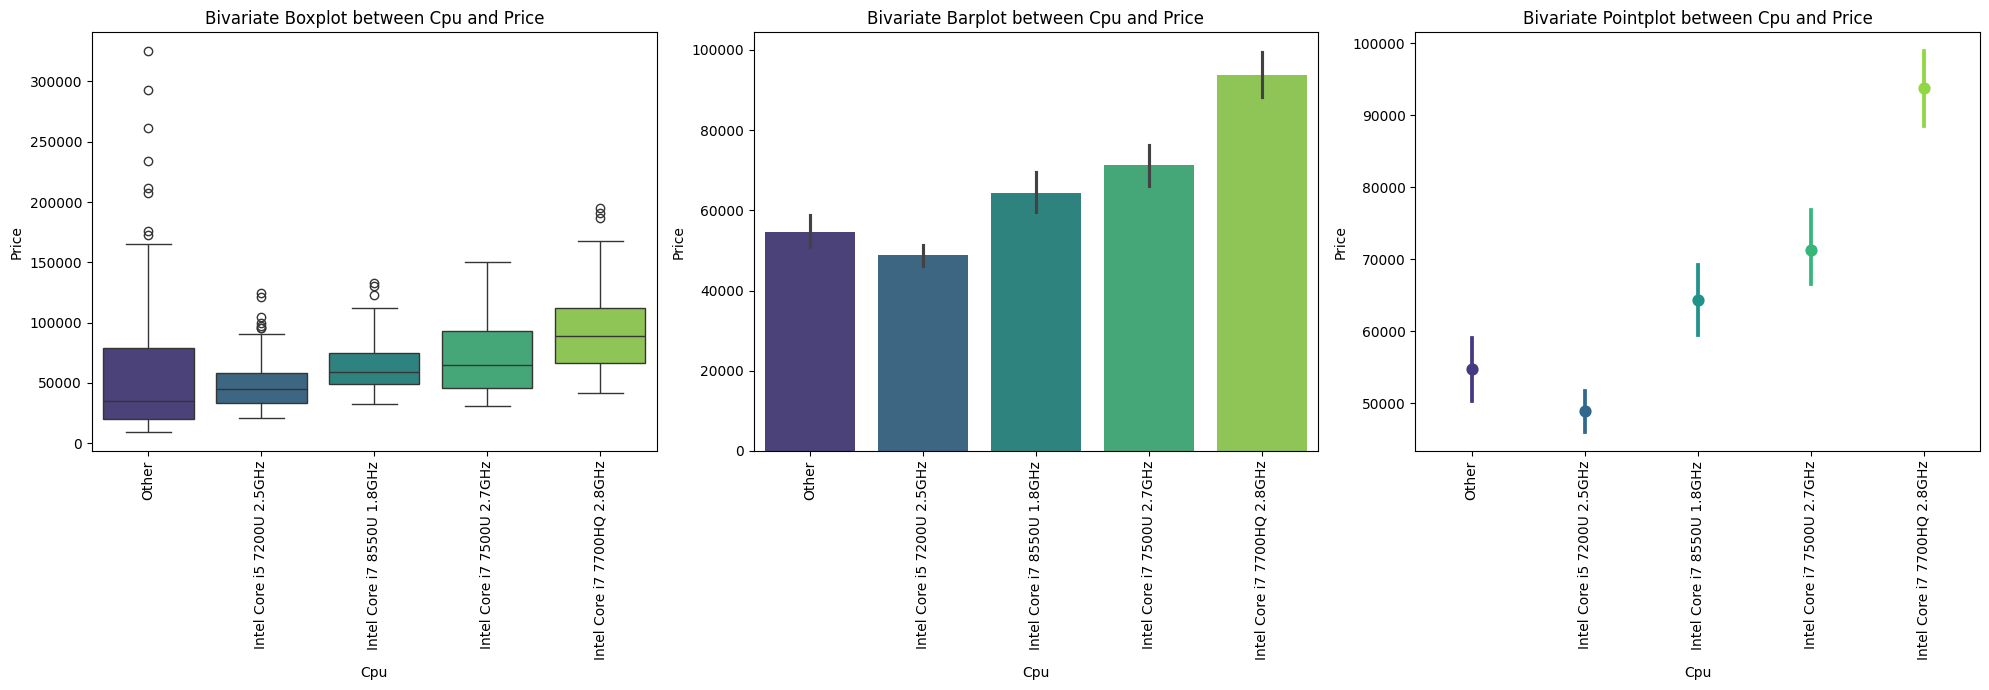

In [68]:
top_5_cpu = df['Cpu'].value_counts().index[:5]
bivariate_analysis(df[df['Cpu'].isin(top_5_cpu)], 'Cpu', 'Price')


C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\902243052.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x_column, y=y_column, palette=color_palette)
C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\902243052.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=x_column, y=y_column, palette=color_palette)
C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\902243052.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data=df, x=x_column, y=y_column, palette=color_palette)


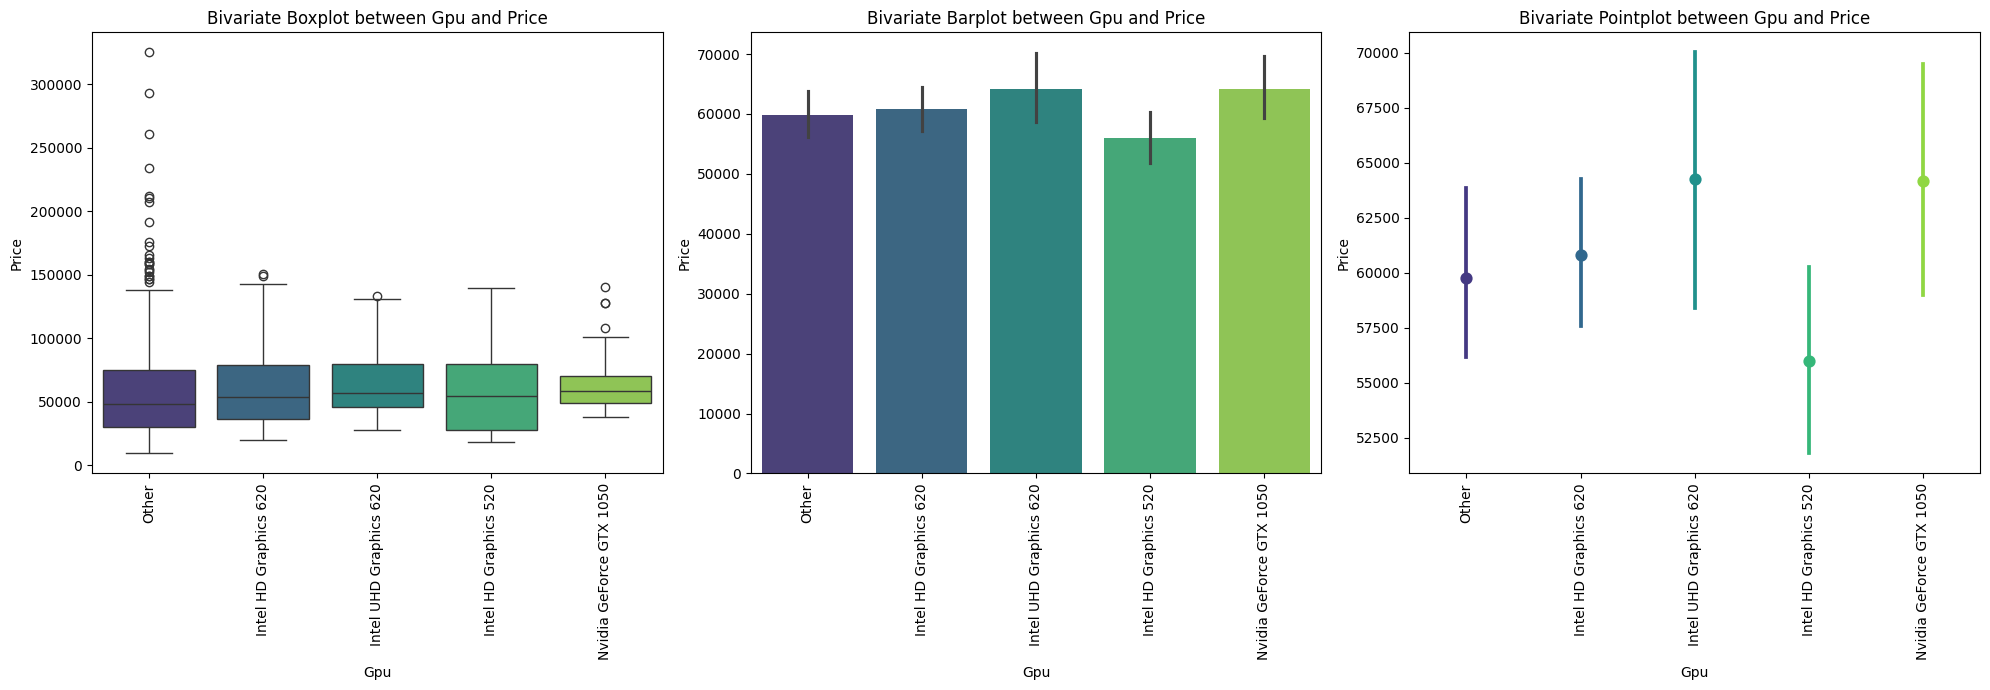

In [69]:
top_5_gpu = df['Gpu'].value_counts().index[:5]

bivariate_analysis(df[df['Gpu'].isin(top_5_gpu)], 'Gpu', 'Price')

C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\902243052.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x_column, y=y_column, palette=color_palette)
C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\902243052.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=x_column, y=y_column, palette=color_palette)
C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\902243052.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data=df, x=x_column, y=y_column, palette=color_palette)


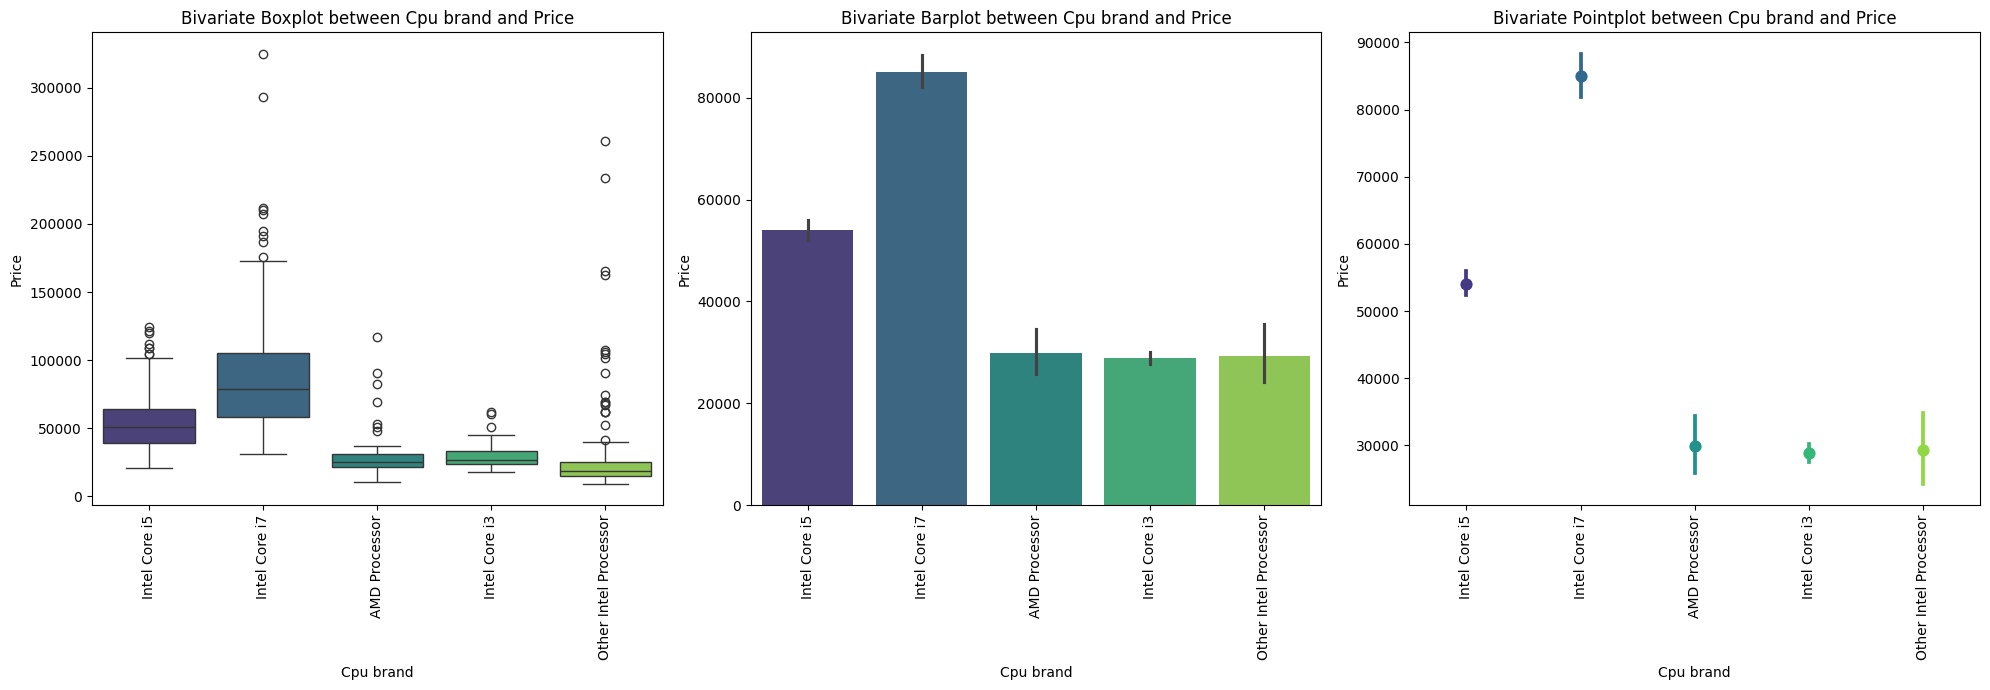

In [70]:
bivariate_analysis(df, 'Cpu brand', 'Price')


C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\902243052.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x_column, y=y_column, palette=color_palette)
C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\902243052.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=x_column, y=y_column, palette=color_palette)
C:\Users\faisa\AppData\Local\Temp\ipykernel_14196\902243052.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data=df, x=x_column, y=y_column, palette=color_palette)


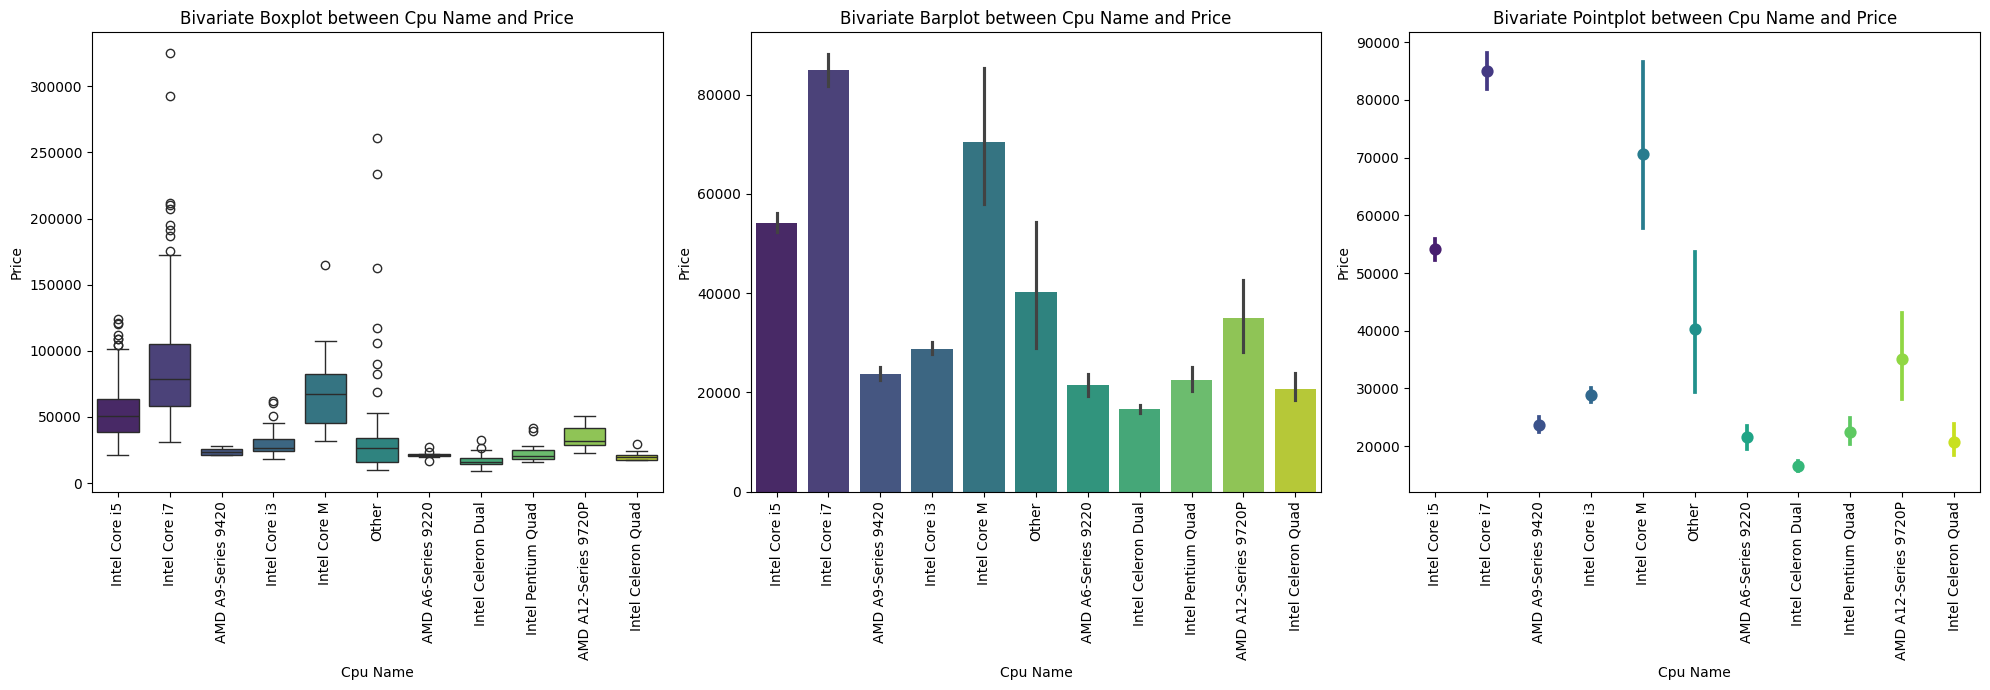

In [71]:
bivariate_analysis(df, 'Cpu Name', 'Price')


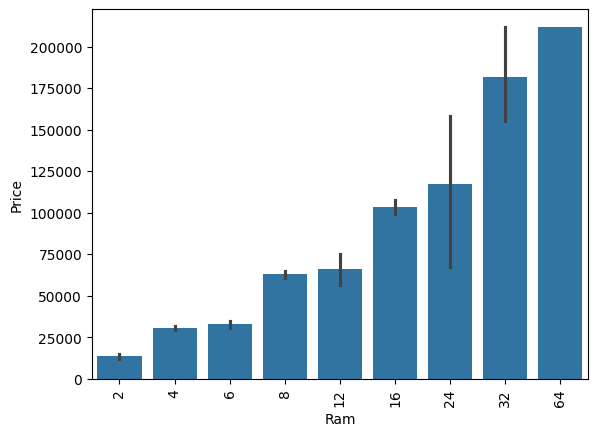

In [72]:
# Ram vs Price
sns.barplot(x=df['Ram'],y=df['Price'])
plt.xticks(rotation='vertical')
plt.show()

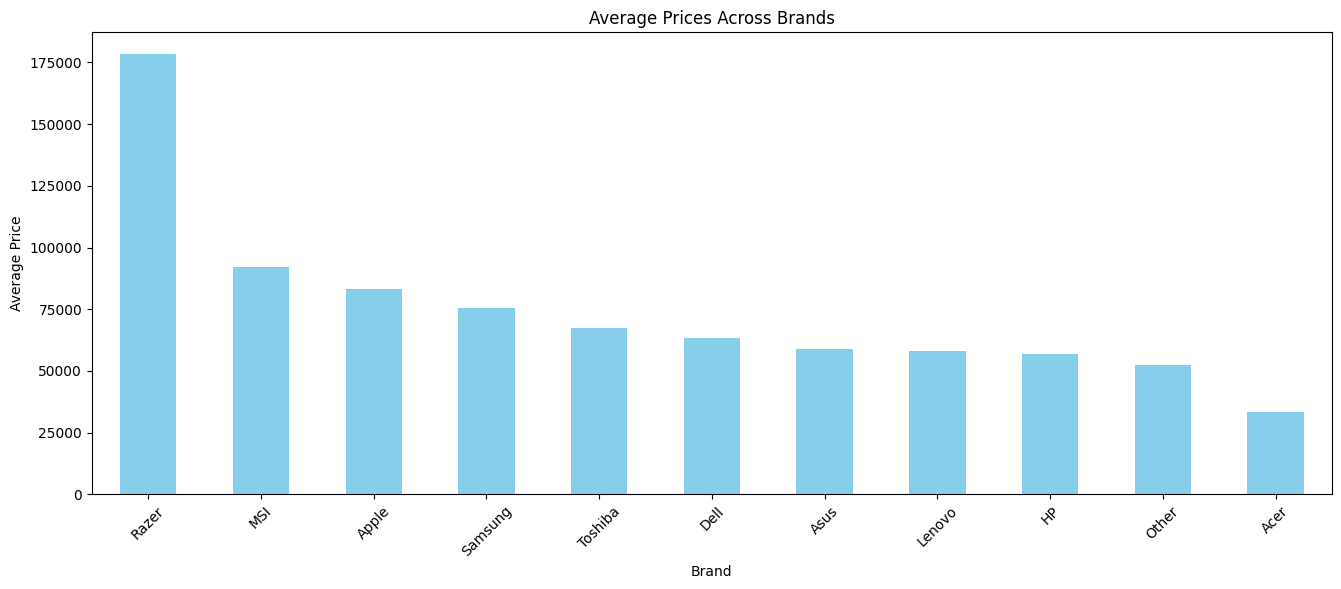

In [73]:
import matplotlib.pyplot as plt

def average_brand_prices(df):
    """
    Compute and visualize the average prices for each brand.

    Parameters:
    - df: DataFrame
    """
    brand_prices = df.groupby('Company')['Price'].mean().sort_values(ascending=False)
    plt.figure(figsize=(16, 6))
    brand_prices.plot(kind='bar', color='skyblue')
    plt.xticks(rotation=45)
    plt.xlabel('Brand')
    plt.ylabel('Average Price')
    plt.title('Average Prices Across Brands')
    plt.show()
average_brand_prices(df)

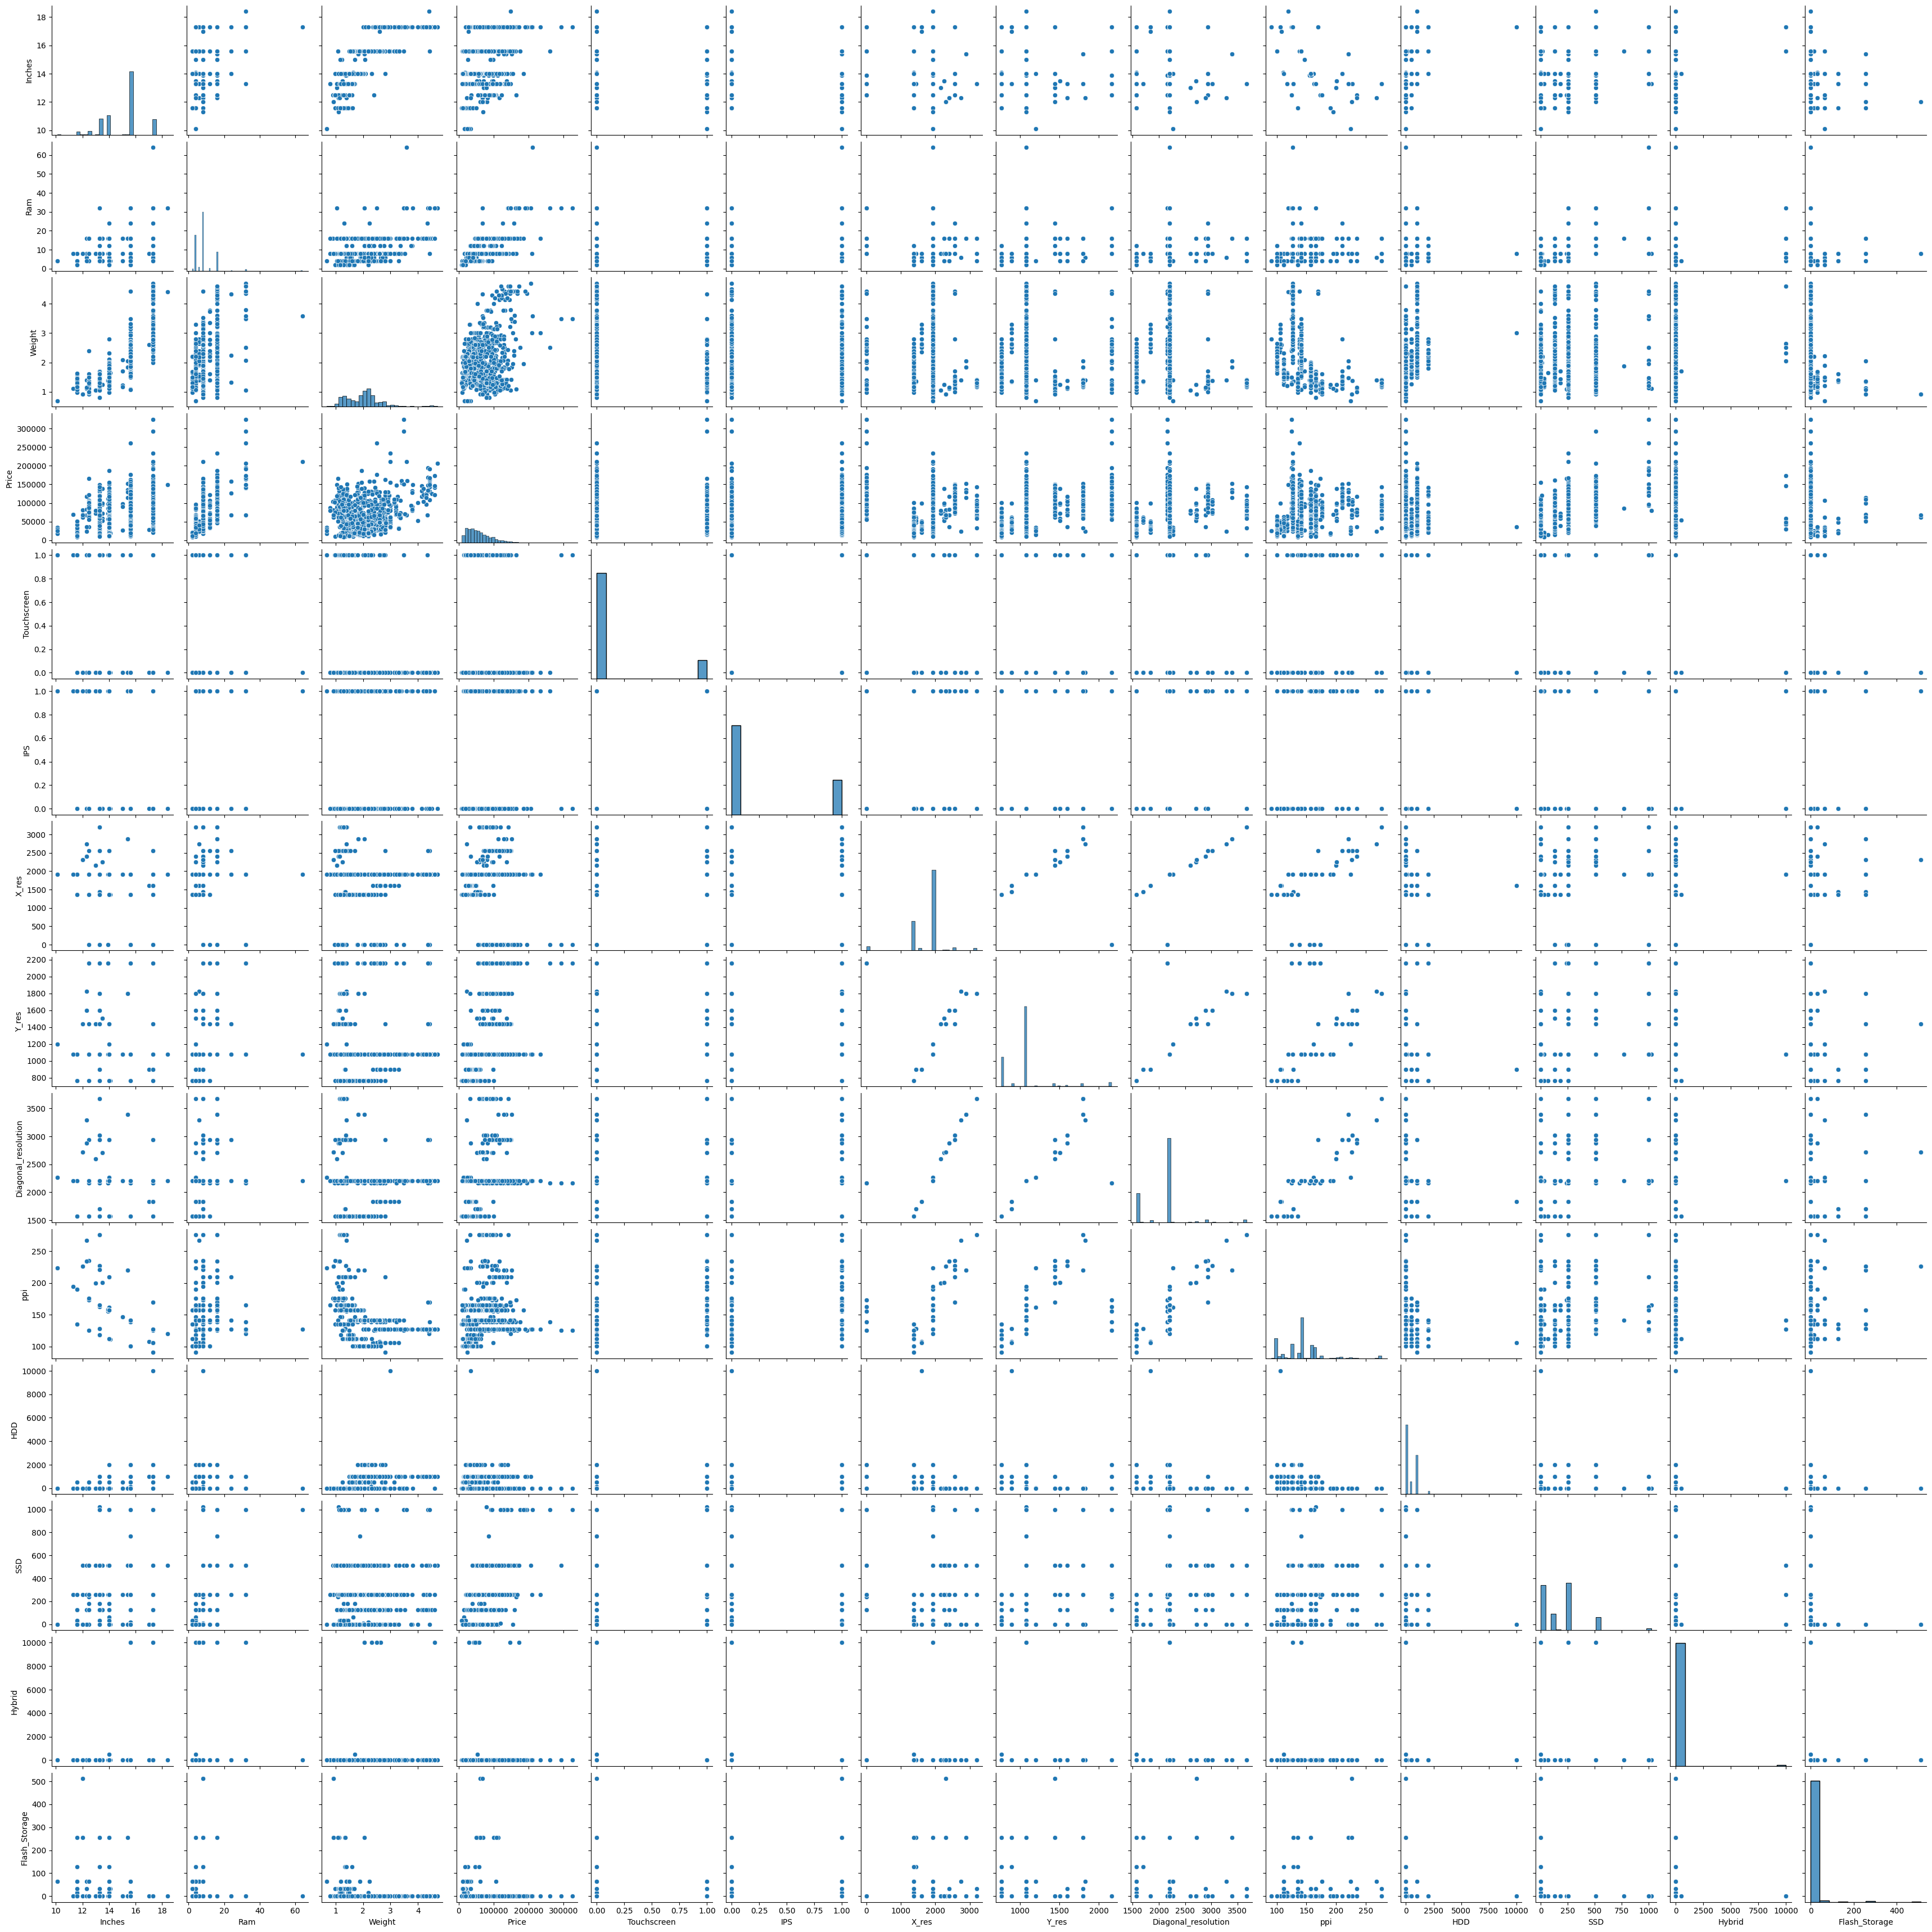

In [74]:
sns.pairplot(df)

In [75]:
import seaborn as sns

def correlation_plot_numeric(df):
    """
    Create a correlation plot for numeric columns in the DataFrame.

    Parameters:
    - df: DataFrame
    """
    numeric_df = df.select_dtypes(include=['int64', 'float64'])
    plt.figure(figsize=(10, 6))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Plot for Numeric Columns')
    plt.show()

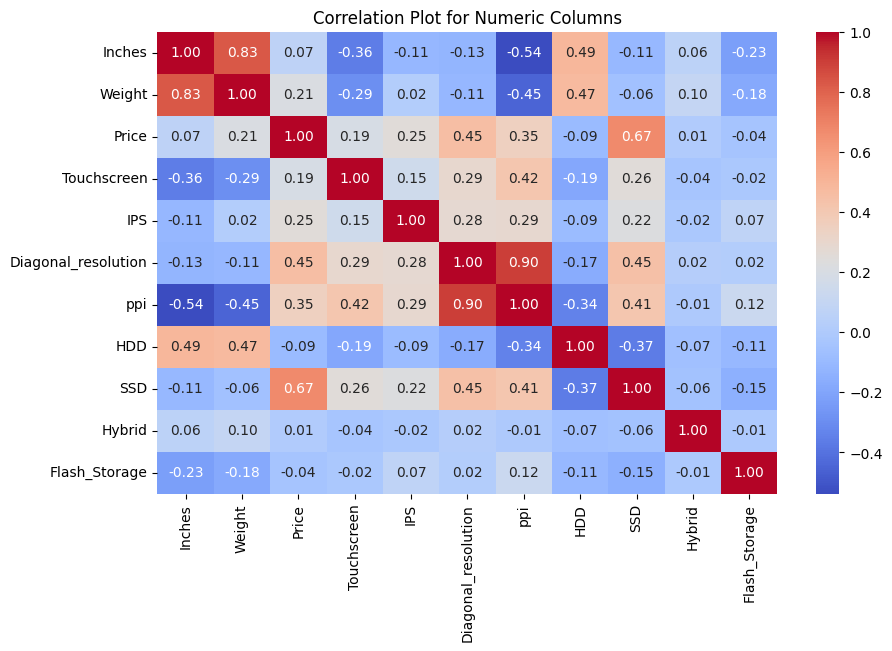

In [76]:
correlation_plot_numeric(df)

In [77]:
# Drop unnecessary columns
df.drop(columns=['Diagonal_resolution','ScreenResolution','Inches','X_res','Y_res','Cpu','Cpu Name','Hybrid','Flash_Storage','OpSys','Gpu'], inplace=True)

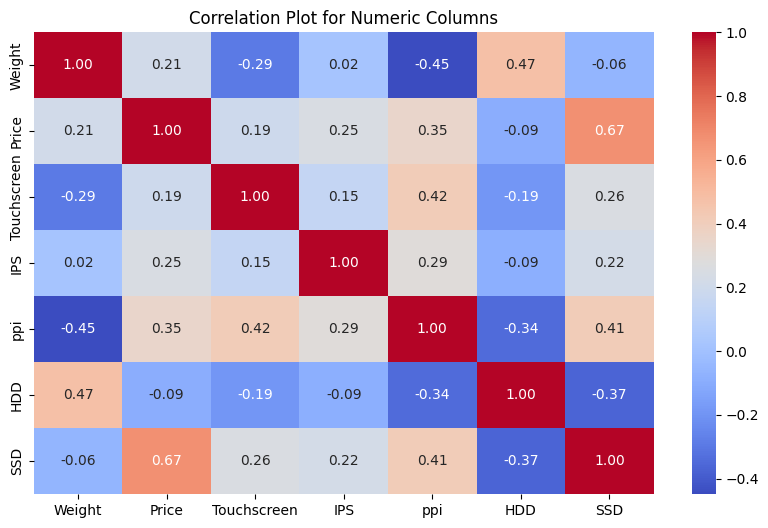

In [78]:
correlation_plot_numeric(df)

In [79]:
df.head()

,Company,TypeName,Ram,Weight,Price,Touchscreen,IPS,ppi,Cpu brand,HDD,SSD,Gpu brand,os
0,Apple,Ultrabook,8,1.37,71378.6832,0,1,226.983005,Intel Core i5,0,128,Intel,Mac
1,Apple,Ultrabook,8,1.34,47895.5232,0,0,127.677940,Intel Core i5,0,0,Intel,Mac
2,HP,Notebook,8,1.86,30636.0000,0,0,141.211998,Intel Core i5,0,256,Intel,Others/No OS/Linux
3,Apple,Ultrabook,16,1.83,135195.3360,0,1,220.534624,Intel Core i7,0,512,AMD,Mac
4,Apple,Ultrabook,8,1.37,96095.8080,0,1,226.983005,Intel Core i5,0,256,Intel,Mac


In [80]:

def explore_data(df):
    # Shape of DataFrame
    shape_headers = ["Number of Rows", "Number of Columns"]
    shape_data = [(df.shape[0], df.shape[1])]
    
    # Info of DataFrame
    info_data = []
    for col in df.columns:
        info_data.append((col, df[col].count(), df[col].dtype))
    
    # Data Types
    dtypes_headers = ["Column", "Data Type"]
    dtypes_data = [(col, df[col].dtype) for col in df.columns]
    
    # Missing Values
    missing_values = df.isnull().sum()
    missing_headers = ["Column", "Missing Values"]
    missing_data = [(col, count if count != 0 else "Zero") for col, count in missing_values.items()]
    
    # Summary Statistics
    summary_stats = df.describe()
    
    # Value Counts Column-wise
    value_counts_data = []
    for column in df.columns:
        counts = df[column].value_counts().reset_index()
        counts.columns = ['Value', 'Count']
        value_counts_data.append((f"Value Counts for {column}", counts))

    # Displaying results using tabulate
    print("\n\n~~~~~ Shape of DataFrame ~~~~~")
    print(tabulate(shape_data, headers=shape_headers, tablefmt="pretty"))

    print("\n\n~~~~~ Info of DataFrame ~~~~~")
    print(tabulate(info_data, headers=["Column", "Non-Null Count", "Dtype"], tablefmt="grid"))

    print("\n\n~~~~~ Data Types ~~~~~")
    print(tabulate(dtypes_data, headers=dtypes_headers, tablefmt="pretty"))

    print("\n\n~~~~~ Missing Values ~~~~~")
    print(tabulate(missing_data, headers=missing_headers, tablefmt="pretty"))

    print("\n\n~~~~~ Summary Statistics ~~~~~")
    print(tabulate(summary_stats, headers='keys', tablefmt="grid"))



explore_data(df)



~~~~~ Shape of DataFrame ~~~~~
+----------------+-------------------+
| Number of Rows | Number of Columns |
+----------------+-------------------+
|      1303      |        13         |
+----------------+-------------------+


~~~~~ Info of DataFrame ~~~~~
+-------------+------------------+---------+
| Column      |   Non-Null Count | Dtype   |
+=============+==================+=========+
| Company     |             1303 | object  |
+-------------+------------------+---------+
| TypeName    |             1303 | object  |
+-------------+------------------+---------+
| Ram         |             1303 | int32   |
+-------------+------------------+---------+
| Weight      |             1303 | float64 |
+-------------+------------------+---------+
| Price       |             1303 | float64 |
+-------------+------------------+---------+
| Touchscreen |             1303 | int64   |
+-------------+------------------+---------+
| IPS         |             1303 | int64   |
+-------------+-----

## Model Building

In [81]:
X = df.drop(columns=['Price'])
y = np.log(df['Price'])

In [82]:
X

,Company,TypeName,Ram,Weight,Touchscreen,IPS,ppi,Cpu brand,HDD,SSD,Gpu brand,os
0,Apple,Ultrabook,8,1.37,0,1,226.983005,Intel Core i5,0,128,Intel,Mac
1,Apple,Ultrabook,8,1.34,0,0,127.677940,Intel Core i5,0,0,Intel,Mac
2,HP,Notebook,8,1.86,0,0,141.211998,Intel Core i5,0,256,Intel,Others/No OS/Linux
3,Apple,Ultrabook,16,1.83,0,1,220.534624,Intel Core i7,0,512,AMD,Mac
4,Apple,Ultrabook,8,1.37,0,1,226.983005,Intel Core i5,0,256,Intel,Mac
...,...,...,...,...,...,...,...,...,...,...,...,...
1298,Lenovo,2 in 1 Convertible,4,1.80,1,1,157.350512,Intel Core i7,0,128,Intel,Windows
1299,Lenovo,2 in 1 Convertible,16,1.30,1,1,276.053530,Intel Core i7,0,512,Intel,Windows
1300,Lenovo,Notebook,2,1.50,0,0,111.935204,Other Intel Processor,0,0,Intel,Windows
1301,HP,Notebook,6,2.19,0,0,100.454670,Intel Core i7,1000,0,AMD,Windows


In [83]:
y

0       11.175755
1       10.776777
2       10.329931
3       11.814476
4       11.473101
          ...    
1298    10.433899
1299    11.288115
1300     9.409283
1301    10.614129
1302     9.886358
Name: Price, Length: 1303, dtype: float64

In [84]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=2)

In [85]:
X_train

,Company,TypeName,Ram,Weight,Touchscreen,IPS,ppi,Cpu brand,HDD,SSD,Gpu brand,os
183,Toshiba,Notebook,8,2.00,0,0,100.454670,Intel Core i5,0,128,Intel,Windows
699,HP,Notebook,4,2.10,0,1,141.211998,Intel Core i7,500,0,AMD,Windows
419,Lenovo,Ultrabook,8,1.75,0,1,157.350512,Intel Core i7,0,256,AMD,Windows
997,Acer,Notebook,4,2.40,0,0,100.454670,Other Intel Processor,500,0,Intel,Windows
502,Lenovo,2 in 1 Convertible,8,1.40,1,1,158.482530,Intel Core i5,0,256,Intel,Windows
...,...,...,...,...,...,...,...,...,...,...,...,...
466,Acer,Notebook,4,2.20,0,0,100.454670,Intel Core i3,500,0,Nvidia,Windows
299,Asus,Ultrabook,16,1.63,0,0,141.211998,Intel Core i7,0,512,Nvidia,Windows
493,Acer,Notebook,8,2.20,0,0,100.454670,AMD Processor,1000,0,AMD,Windows
527,Lenovo,Notebook,8,2.20,0,0,100.454670,Intel Core i3,2000,0,Nvidia,Others/No OS/Linux


In [86]:
X_test

,Company,TypeName,Ram,Weight,Touchscreen,IPS,ppi,Cpu brand,HDD,SSD,Gpu brand,os
248,HP,Notebook,4,1.49,0,1,165.632118,Intel Core i5,500,0,Intel,Windows
556,Other,Notebook,4,1.35,0,1,165.632118,Other Intel Processor,0,0,Intel,Windows
693,Lenovo,2 in 1 Convertible,8,1.42,1,0,209.800683,Intel Core i7,0,256,Intel,Windows
387,Dell,Workstation,8,2.23,0,0,141.211998,Intel Core i5,500,0,AMD,Windows
781,Asus,Gaming,16,4.30,0,1,127.335675,Intel Core i7,1000,256,Nvidia,Windows
...,...,...,...,...,...,...,...,...,...,...,...,...
697,Asus,2 in 1 Convertible,4,1.20,1,0,176.232574,Other Intel Processor,0,0,Intel,Others/No OS/Linux
172,Lenovo,Notebook,4,2.20,0,0,100.454670,AMD Processor,500,0,AMD,Others/No OS/Linux
322,Asus,Notebook,8,2.00,0,0,157.350512,Intel Core i7,0,256,Intel,Windows
1020,Dell,2 in 1 Convertible,4,2.08,1,1,141.211998,Intel Core i3,1000,0,Intel,Windows


In [92]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score,mean_absolute_error

In [91]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,ExtraTreesRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

## Linear Regression

In [96]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(drop='first'),[0,1,7,10,11])
],remainder='passthrough')

step2 = LinearRegression()

pipe = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

R2 score 0.8167412113306474
MAE 0.21438091526040554


## Ridge

In [97]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(drop='first'),[0,1,7,10,11])
],remainder='passthrough')

step2 = Ridge(alpha=10)

pipe = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

R2 score 0.8184763410309306
MAE 0.2118842660584136


## Lasso

In [99]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(drop='first'),[0,1,7,10,11])
],remainder='passthrough')

step2 = Lasso(alpha=0.001)

pipe = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

R2 score 0.8161040677896445
MAE 0.21359124137796448


## KNN

In [101]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(drop='first'),[0,1,7,10,11])
],remainder='passthrough')

step2 = KNeighborsRegressor(n_neighbors=4)

pipe = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

R2 score 0.824177251468415
MAE 0.19868999842730525


# Decison Trees

In [102]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(drop='first'),[0,1,7,10,11])
],remainder='passthrough')

step2 = DecisionTreeRegressor(max_depth=8)

pipe = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

R2 score 0.8541179714131293
MAE 0.1780658829652232


## SVM

In [103]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(drop='first'),[0,1,7,10,11])
],remainder='passthrough')

step2 = SVR(kernel='rbf',C=10000,epsilon=0.1)

pipe = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

R2 score 0.8615424766073255
MAE 0.18595644823513843


## Random Forest

In [140]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(drop='first'),[0,1,7,10,11])
],remainder='passthrough')

step2 = RandomForestRegressor(n_estimators=300,
                              random_state=9,
                              max_samples=0.7,
                              max_features=0.65,
                              max_depth=13)

pipe = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

R2 score 0.8886297957983247
MAE 0.15716850287878548


## Extra Trees

In [116]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(drop='first'),[0,1,7,10,11])
],remainder='passthrough')

step2 = ExtraTreesRegressor(n_estimators=100,
                              random_state=3,
                              max_samples=None,
                              max_features=0.75,
                              max_depth=15)

pipe = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

R2 score 0.8755663002496918
MAE 0.16322866010049353


## ADABOOST

In [122]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(drop='first'),[0,1,7,10,11])
],remainder='passthrough')

step2 = AdaBoostRegressor(n_estimators=200,learning_rate=0.55)

pipe = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

R2 score 0.8151813754486049
MAE 0.21959313293741817


## Gradient Boost

In [125]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(drop='first'),[0,1,7,10,11])
],remainder='passthrough')

step2 = GradientBoostingRegressor(n_estimators=500)

pipe = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

R2 score 0.8903742105490098
MAE 0.15760049133630027


## Xgboost

In [131]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(drop='first'),[0,1,7,10,11])
],remainder='passthrough')

step2 = XGBRegressor(n_estimators=100,max_depth=7,learning_rate=0.4)

pipe = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

R2 score 0.8935683957617037
MAE 0.15422519511852678


## Voting Regressor

In [137]:
from sklearn.ensemble import VotingRegressor,StackingRegressor

step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(drop='first'),[0,1,7,10,11])
],remainder='passthrough')

rf = RandomForestRegressor(n_estimators=350,random_state=3,max_samples=10,max_features=0.75,max_depth=10)
gbdt = GradientBoostingRegressor(n_estimators=100,max_features=0.5)
xgb = XGBRegressor(n_estimators=250,learning_rate=0.3,max_depth=5)
et = ExtraTreesRegressor(n_estimators=200,random_state=3,max_samples=None,max_features=0.75,max_depth=10)

step2 = VotingRegressor([('rf', rf), ('gbdt', gbdt), ('xgb',xgb), ('et',et)],weights=[5,4,3,2])

pipe = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

R2 score 0.8667902228536902
MAE 0.17939760703515145


## Stacking

In [139]:
from sklearn.ensemble import VotingRegressor,StackingRegressor

step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(drop='first'),[0,1,7,10,11])
],remainder='passthrough')


estimators = [
    ('rf', RandomForestRegressor(n_estimators=350,random_state=3,max_samples=0.5,max_features=0.75,max_depth=15)),
    ('gbdt',GradientBoostingRegressor(n_estimators=100,max_features=0.5)),
    ('xgb', XGBRegressor(n_estimators=25,learning_rate=0.3,max_depth=5))
]

step2 = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=100))

pipe = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

R2 score 0.8832602672429232
MAE 0.16302991081220466


In [141]:
import pickle

pickle.dump(df,open('df.pkl','wb'))
pickle.dump(pipe,open('pipe.pkl','wb'))